To Do:
- Analisar tweets repetidos mais a fundo (possiveis bots)


Avaliar fatores de impacto nos tweets
- Que tipo de conteúdo resulta em mais engajamento (positivo ou negativo)?
- Que tipo de conteúdo resulta em mais conteúdo ofensivo
- Desenhar grafo de interações (https://towardsdatascience.com/social-network-analysis-from-theory-to-applications-with-python-d12e9a34c2c7)


Desenhar timeline do projeto na apresentação
  

# Carregando e preparando dados

In [1]:
from datetime import datetime
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
from scipy import stats 
from scipy.stats import ttest_1samp, ttest_ind
import seaborn as sns
import sys
import tabulate
from tqdm import tqdm

sys.path.append("../")
pd.options.display.max_colwidth = 50
sns.set_style("whitegrid")

In [2]:
candidates_file_path = "../data/processed/se_candidates_output_3.csv"
raw_cand_df = pd.read_csv(candidates_file_path, sep=";", encoding="utf-8")

print(raw_cand_df.shape)
raw_cand_df.info()

(1250, 79)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DT_GERACAO                     1250 non-null   object 
 1   HH_GERACAO                     1250 non-null   object 
 2   ANO_ELEICAO                    1250 non-null   int64  
 3   CD_TIPO_ELEICAO                1250 non-null   int64  
 4   NM_TIPO_ELEICAO                1250 non-null   object 
 5   NR_TURNO                       1250 non-null   int64  
 6   CD_ELEICAO                     1250 non-null   int64  
 7   DS_ELEICAO                     1250 non-null   object 
 8   DT_ELEICAO                     1250 non-null   object 
 9   TP_ABRANGENCIA                 1250 non-null   object 
 10  SG_UF                          1250 non-null   object 
 11  SG_UE                          1250 non-null   object 
 12  NM_UE                          1250 n

In [3]:
est_tweets_file_path = (
    "../data/processed/sp_elected_stdep_tweets-ft_hf_classified.csv"
)
est_raw_tweets_df = pd.read_csv(est_tweets_file_path, sep=";", encoding="utf-8")

print(est_raw_tweets_df.shape)
est_raw_tweets_df.info()

(46973, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46973 entries, 0 to 46972
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       46973 non-null  object 
 1   date                      46973 non-null  object 
 2   content                   46973 non-null  object 
 3   user                      46973 non-null  object 
 4   reply_count               46973 non-null  int64  
 5   retweet_count             46973 non-null  int64  
 6   like_count                46973 non-null  int64  
 7   quote_count               46973 non-null  int64  
 8   in_reply_to_id            43445 non-null  float64
 9   in_reply_to_user          43328 non-null  object 
 10  conversation_id           46973 non-null  object 
 11  conversation_user         46973 non-null  object 
 12  ru_bert_base_label        46973 non-null  bool   
 13  ru_bert_base_score        46973 non-null  float64

In [4]:
fed_tweets_file_path = (
    "../data/processed/sp_elected_feddep_tweets-ft_hf_classified.parquet"
)
fed_raw_tweets_df = pd.read_parquet(fed_tweets_file_path)

print(fed_raw_tweets_df.shape)
fed_raw_tweets_df.info()

(78193, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 78193 entries, 220 to 215619
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   id                        78193 non-null  object             
 1   date                      78193 non-null  datetime64[ns, UTC]
 2   user                      78193 non-null  object             
 3   content                   78193 non-null  object             
 4   in_reply_to_id            75049 non-null  object             
 5   in_reply_to_user          74540 non-null  object             
 6   conversation_id           78193 non-null  object             
 7   conversation_user         78193 non-null  object             
 8   reply_count               78193 non-null  int64              
 9   retweet_count             78193 non-null  int64              
 10  like_count                78193 non-null  int64              
 11  

In [5]:
# Mantendo cópia dos datasets iniciais
cand_df = raw_cand_df
est_tts_df = est_raw_tweets_df
fed_tts_df = fed_raw_tweets_df

## Dataset de Candidatos

In [6]:
# Removendo colunas não utilizadas
cand_cols = [
    "SG_UF",
    "DS_CARGO",
    "SQ_CANDIDATO",
    "NM_URNA_CANDIDATO",
    "NR_PARTIDO",
    "SG_PARTIDO",
    "NM_MUNICIPIO_NASCIMENTO",
    "NR_IDADE_DATA_POSSE",
    "DS_GENERO",
    "DS_GRAU_INSTRUCAO",
    "DS_ESTADO_CIVIL",
    "DS_COR_RACA",
    "DS_OCUPACAO",
    "DS_SIT_TOT_TURNO",
    "ST_REELEICAO",
    "TW_USER",
    "TW_followersCount",
    "TW_friendsCount",
    "TW_statusesCount",
    "TW_favouritesCount",
]
cand_df = cand_df[cand_cols]
print(cand_df.shape)

(1250, 20)


In [7]:
# Filtrando somente os deputados estaduais de SP
cand_df = cand_df[cand_df["SG_UF"] == "SP"]
cand_df = cand_df[(cand_df["DS_CARGO"] == "DEPUTADO ESTADUAL") | (cand_df["DS_CARGO"] == "DEPUTADO FEDERAL")]
cand_df.shape

(595, 20)

In [8]:
# Convertendo usernames para minusculo
cand_df["TW_USER"] = cand_df["TW_USER"].str.lower()

In [9]:
# Salvando arquivos consolidado
output_path = "../data/processed/"
file_name = 'sp_elected_est_fed_dep_candidates'
output_suffix = "analysis"
file_format = 'parquet'

output_file = f"{output_path}{file_name}-{output_suffix}.{file_format}"
print(output_file)

cand_df.to_parquet(output_file)

../data/processed/sp_elected_est_fed_dep_candidates-analysis.parquet


## Dataset de Tweets

In [10]:
# Extraindo id dos tweets com url, para padronizar a identificação
def extract_id_from_url(url):
    return url.split('/')[-1]

def convert_url_to_tweet_id(df):
    if 'url' not in df.columns:
        return df
    df['id'] = df['url'].apply(extract_id_from_url)
    return df

if not 'id' in est_tts_df:
    convert_url_to_tweet_id(est_tts_df)

if not 'id' in fed_tts_df:
    convert_url_to_tweet_id(fed_tts_df)

In [11]:
# Removendo colunas não utilizadas. Vamos usar somente a classificação do modelo refinado.
tweet_cols = [
    "id",
    "date",
    "content",
    "user",
    "in_reply_to_user",
    "conversation_user",
    "ft_rc_bert_base_label",
    "ft_rc_bert_base_score",
]
est_tts_df = est_tts_df[tweet_cols]
fed_tts_df = fed_tts_df[tweet_cols]
print(est_tts_df.shape, fed_tts_df.shape)

(46973, 8) (78193, 8)


In [12]:
tts_df = pd.concat([est_tts_df, fed_tts_df])
tts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125166 entries, 0 to 215619
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     125166 non-null  object 
 1   date                   125166 non-null  object 
 2   content                125166 non-null  object 
 3   user                   125166 non-null  object 
 4   in_reply_to_user       117868 non-null  object 
 5   conversation_user      125166 non-null  object 
 6   ft_rc_bert_base_label  125166 non-null  bool   
 7   ft_rc_bert_base_score  125166 non-null  float64
dtypes: bool(1), float64(1), object(6)
memory usage: 7.8+ MB


In [13]:
def extract_account_tags(content):
    words = content.split(' ')
    
    def is_not_account_tag(word):
        if len(word) > 0:
            return word[0] != '@'
        return True
        
    words_list = list(filter(is_not_account_tag, words))
    return ' '.join(words_list)

tts_df['filtered_content'] = tts_df['content'].apply(extract_account_tags)

In [14]:
# Adicionando coluna com o tamanho dos tweets
tts_df['content_length'] = tts_df['content'].str.len()
tts_df['filtered_content_length'] = tts_df['filtered_content'].str.len()

In [15]:
# Renomeando a coluna da classificação para simplificar o processo
tts_df.rename(columns={
    "ft_rc_bert_base_label": "class_label", 
    "ft_rc_bert_base_score": "class_score"
}, inplace=True)

In [16]:
# Convertendo a coluna de data para o tipo correto
tts_df.date = pd.to_datetime(tts_df.date)
tts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125166 entries, 0 to 215619
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   id                       125166 non-null  object             
 1   date                     125166 non-null  datetime64[ns, UTC]
 2   content                  125166 non-null  object             
 3   user                     125166 non-null  object             
 4   in_reply_to_user         117868 non-null  object             
 5   conversation_user        125166 non-null  object             
 6   class_label              125166 non-null  bool               
 7   class_score              125166 non-null  float64            
 8   filtered_content         125166 non-null  object             
 9   content_length           125166 non-null  int64              
 10  filtered_content_length  125166 non-null  int64              
dtypes: bool(1), d

In [17]:
# Filtrando somente os tweets do período desejado
local_tz = pytz.timezone("America/Sao_Paulo")
since = datetime(year=2022, month=9, day=1, tzinfo=local_tz)
until = datetime(year=2022, month=11, day=1, tzinfo=local_tz)

tts_df = tts_df[(tts_df["date"] >= since) & (tts_df["date"] <= until)]
tts_df.shape

(125166, 11)

In [18]:
# Removendo tweets com informação faltando de reply
# Se 'user' é diferente de 'conversation_user', então o tweet deveria ter também 'in_reply_to_user'
# Se não tiver, é por que houve algum erro durante o scraping, ou com o tweet respondido
tts_df = tts_df[
    ~(
        (tts_df["in_reply_to_user"].isnull())
        & (tts_df["user"] != tts_df["conversation_user"])
    )
]
tts_df.shape

(125112, 11)

In [19]:
# Convertendo usernames para minusculo
tts_df.user = tts_df.user.str.lower()
tts_df.conversation_user = tts_df.conversation_user.str.lower()
tts_df.in_reply_to_user = tts_df.in_reply_to_user.str.lower()

## Juntando os datasets

In [20]:
df = pd.merge(
    tts_df, cand_df, left_on="conversation_user", right_on="TW_USER", how="left"
)
print(df.shape)
df.info()

(125112, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125112 entries, 0 to 125111
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   id                       125112 non-null  object             
 1   date                     125112 non-null  datetime64[ns, UTC]
 2   content                  125112 non-null  object             
 3   user                     125112 non-null  object             
 4   in_reply_to_user         117868 non-null  object             
 5   conversation_user        125112 non-null  object             
 6   class_label              125112 non-null  bool               
 7   class_score              125112 non-null  float64            
 8   filtered_content         125112 non-null  object             
 9   content_length           125112 non-null  int64              
 10  filtered_content_length  125112 non-null  int64              
 11  

In [21]:
# Adicionando coluna para indicar se o usuário do tweet é um candidato
deputies_usernames = list(df.TW_USER.str.lower().unique())
df["user_is_candidate"] = df["user"].apply(lambda u: u in deputies_usernames)

In [22]:
# Salvando arquivos consolidado
output_path = "../data/processed/"
file_name = 'sp_elected_est_fed_dep_tweets'
output_suffix = "analysis"
file_format = 'parquet'

output_file = f"{output_path}{file_name}-{output_suffix}.{file_format}"
print(output_file)

df.to_parquet(output_file)

../data/processed/sp_elected_est_fed_dep_tweets-analysis.parquet


# EDA

## Glossário

- **tweet**: qualquer postagem feita no Twitter
- **reply**: tweets feitos em resposta direta a outro *tweet*
- **thread** (conversa): uma sequencia de *tweets*, composta pelo *tweet* inicial, *replies* feitas a esse *tweet*, *replies* feitas a essas *replies*, e assim sucessivamente

In [23]:
# Vamos definir uma variável para agrupar os insights e facilitar a análise final
insights = []
# insight_template = {
#     'col_1': 'coluna 1',
#     'col_2': 'coluna 2',
#     'association': 'associação entre colunas 1 e 2',
#     'extra': None, 
# }

In [24]:
# Checando alguns exemplos de tweets com conteúdo ofensivo
df[df['class_label'] == True].sample(10)['content'].values

array(['@andreawerner_ ROBERTO JEFFERSON É BOLSONARO',
       '@esuplicy @marciofrancasp Sim, reelegendo Bolsonaro em primeiro turno, afastando mais uma vez essa esquerda podre, o Brasil será muito feliz!🙏🙏🙏',
       '@andreawerner_ Se você é pastor, como faz? Está vendo o maior bandido da história do planeta Terra, aquele que assaltou bilhões, quem sabe trilhões de reais, concorrendo a Presidência. Vai ficar quieto?\n\nChico Xavier não ficou quieto. \n\nhttps://t.co/QzVbF6zHLD',
       '@samiabomfim @ElizabethdeSiq1 @pejulio !!! BOLSONARO E "PADRE"KELMON....SEMELHANTE ATRAI SEMELHANTE....FRAUDE PURA!!!!!',
       '@luizaerundina Resumo !!! Lula é ladrão , e Pilatos entregou Jesus e Barrabas!!\nQuem foi crucificado?',
       '@pauloteixeira13 Tudo pra desviar o assunto PEDOFILIA',
       '@samiabomfim Você não tem escrúpulo.\nMas a verdade SEMPRE vem.\nO desespero é tremendo. \n\n#PTNuncaMais https://t.co/eHVcyJNcFi',
       '@samiabomfim Tadinha...... é insignificante.',
       '@sami

## Funções auxiliares
Vamos começar definindo algumas funções para padronizar e facilitar nossas análises

### Funções de Visualização

In [25]:
figsize = (20, 4)
percentiles = [0.05, 0.25, 0.5, 0.75, 0.95]
cand_id_cols = ['TW_USER']

def side_by_side(*dfs):
    """Exibe dataframes lado a lado"""
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

def print_quant_data(df, cols, sort_by):
    """Exibe lado a lado as descrições estatísticas das colunas, e os 10 maiores valores de coluna passada"""
    side_by_side(
        df[cols].describe(percentiles=percentiles),
        df[cand_id_cols + cols].sort_values(sort_by, ascending=False).head(10)
    )

def plot_histograms(df, cols, figsize=figsize):
    """Plota histogramas das colunas passadas lado a lado"""
    fig, ax = plt.subplots(1, len(cols), figsize=figsize)
    for i, col in enumerate(cols):
        sns.histplot(
            df,
            x=col,
            kde=True,
            ax=ax[i],
        ).set(title=f'Histograma de {col}')  

def plot_boxplots(df, cols, figsize=figsize):
    """Plota boxplots das colunas passadas um acima do outro"""
    plt.figure(figsize=figsize)
    sns.boxplot(
        data=df[cols],
        orient='h',
    ).set(title=f'Boxplot de {cols}')
    
def plot_cols(df, cols, figsize=figsize):
    """Plota histogramas e boxplots das colunas passadas"""
    plot_histograms(df, cols, figsize)
    plt.show()
    plot_boxplots(df, cols, figsize)

def plot_corr_heatmap(df, figsize=(12, 4)):
    """Plota um mapa de calor com as correlações entre as colunas passadas"""
    plt.figure(figsize=figsize)
    sns.heatmap(
        df.corr(),
        annot=True, fmt='.2f',
        cmap='PRGn', vmin=-1, vmax=1,
        mask=np.triu(np.ones_like(df.corr()))
    )
    

### Funções para Testes de Hipóteses

In [26]:
def t_student_test(df, x_col, y_col='class_label', y_val_0=False, y_val_1=True, alpha=0.05, print_results=True):
    """Teste T de Student para comparar a diferença entre as médias de `x_col`, agrupado de acordo com `y_col`"""
    sample_0 = df[df[y_col] == y_val_0][x_col]
    sample_1 = df[df[y_col] == y_val_1][x_col]
    t_stat, p_value = ttest_ind(sample_0, sample_1)

    msg = f'Coluna {x_col} agrupada por {y_col}: {p_value=}, {t_stat=}\n'
    
    if p_value <= alpha:
        msg += f'Diferença significativa encontrada'
        insights.append(msg)
    else:
        msg += f'Sem diferença significativa'

    if print_results:
        print(msg)

    return p_value, t_stat


def t_test_candidate_quali_columns(cand_df, x_cols, y_col, y_val_0, y_val_1, alpha=0.05):
    """Realiza um teste T de Student com cada coluna de `x_cols`, comparando as médias agrupadas por `y_val`"""
    results = []
    for col in x_cols:
        p_value, t_stat = t_student_test(cand_df, x_col=col, y_col=y_col, y_val_0=y_val_0, y_val_1=y_val_1, alpha=alpha, print_results=False)
        result = {
            'col': col,
            'p_value': p_value, 
            't_stat': t_stat,
            'sig_dif': bool(p_value <= alpha),
        }
        results.append(result)
    
    ttest_df = pd.DataFrame(results)
    
    dif_cols = list(ttest_df[ttest_df['sig_dif'] == True].col)
    if dif_cols:
        print(f'Diferença significativa encontrada nas colunas: {dif_cols}\n')
        display(ttest_df[ttest_df['sig_dif'] == True])    
        for i, col in enumerate(dif_cols):
            plt.figure(figsize=(20, 2))
            p = sns.boxplot(
                data=cand_df[[y_col] + dif_cols],
                x=col,
                y=y_col,
                order=[y_val_1, y_val_0],
                palette='Set1',
            )
            p.set(
                title=f'Boxplot de {col}', xlabel=None, ylabel=None,
            )
            plt.show()
    else:
        print(f'Nenhuma coluna apresentou diferença significativa para {y_col}')

    return ttest_df

## Exploração inicial dos dados

#### Dados de conteúdo ofensivo

False    0.831951
True     0.168049
Name: class_label, dtype: float64 



[Text(0.5, 1.0, 'Histograma de score das classificações')]

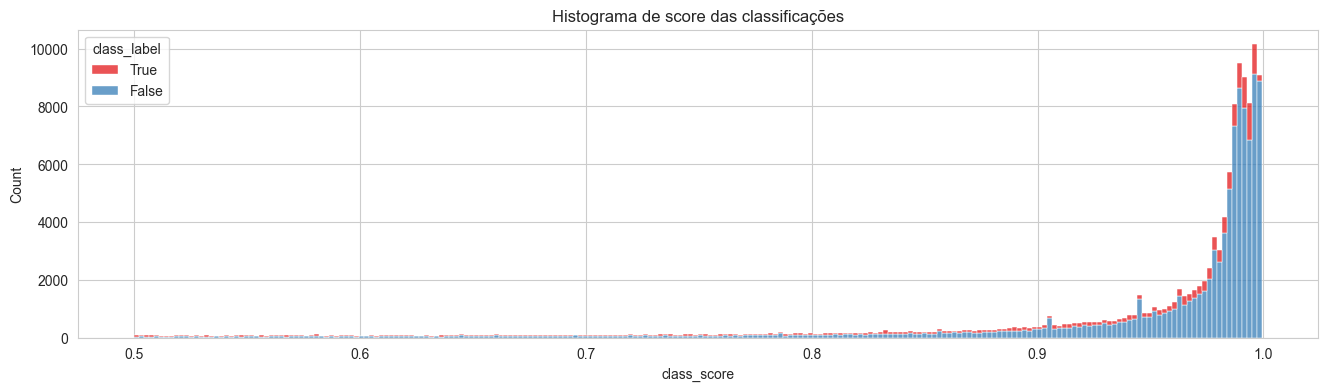

In [27]:
# Avaliando a distribuição e score de ofensas no dataset
print(df['class_label'].value_counts(normalize=True), '\n')

plt.figure(figsize=(16, 4))
sns.histplot(
    df,
    x='class_score',
    hue='class_label',
    hue_order=[True, False],
    palette='Set1',
    multiple='stack',
).set(title="Histograma de score das classificações")

In [28]:
df['class_score'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

count    125112.000000
mean          0.936455
std           0.102501
min           0.500001
10%           0.798449
25%           0.936217
50%           0.982340
75%           0.991623
90%           0.996392
max           0.999262
Name: class_score, dtype: float64

<Axes: xlabel='class_score', ylabel='class_label'>

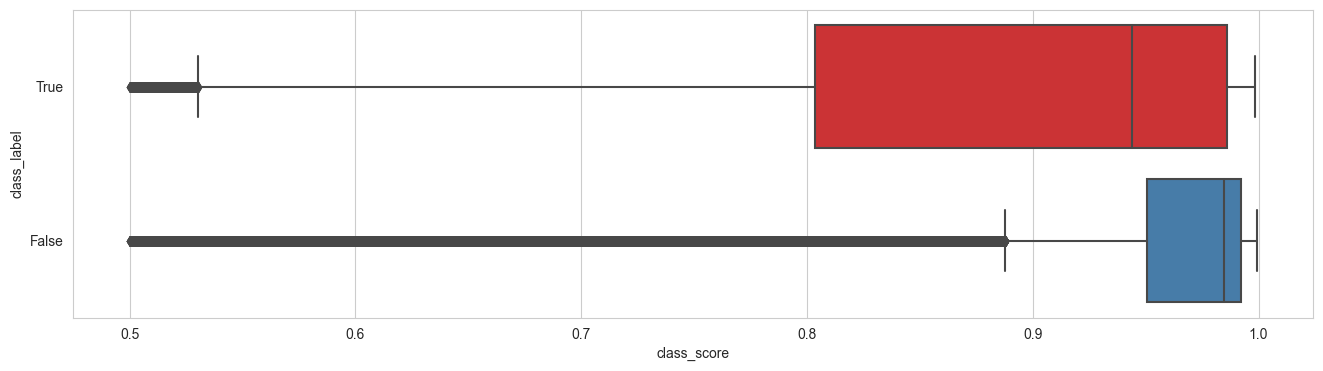

In [29]:
plt.figure(figsize=(16, 4))
sns.boxplot(
    data=df,
    x='class_score',
    y=df['class_label'].astype(str),
    palette='Set1',
    order=['True', 'False'],
)

In [30]:
t_student_test(df, x_col='class_score')

Coluna class_score agrupada por class_label: p_value=0.0, t_stat=96.15681667776525
Diferença significativa encontrada


(0.0, 96.15681667776525)

#### Dados de tamanho dos tweets

[Text(0.5, 1.0, 'Histograma de filtered_content_length por classe')]

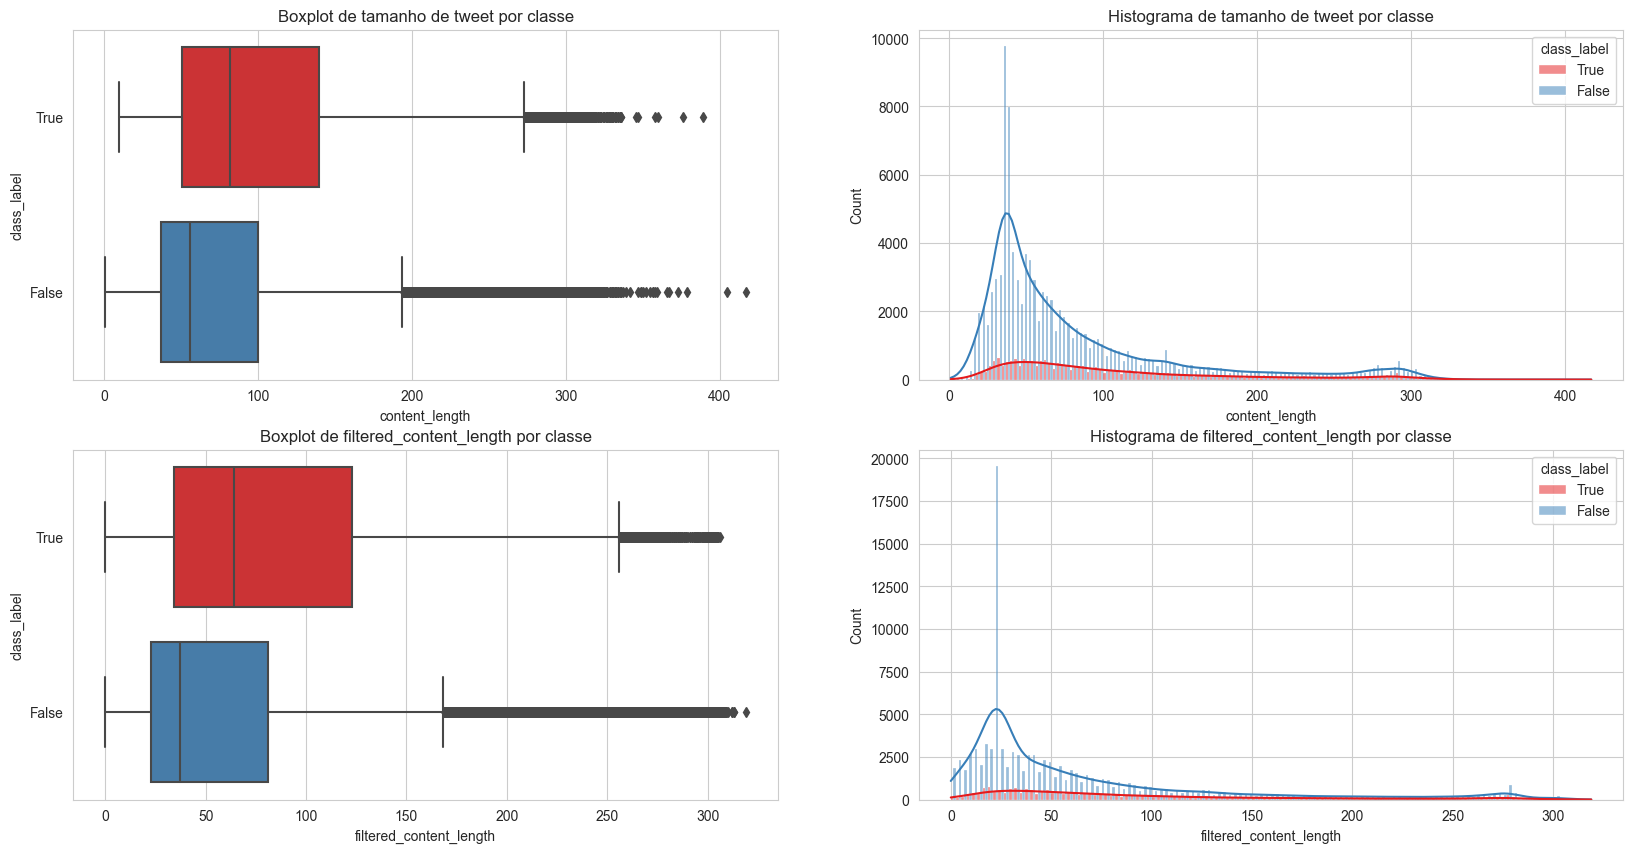

In [31]:
# Checando a distribuição do tamanho dos tweets
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(
    data=df,
    x='content_length',
    y=df['class_label'].astype(str),
    palette='Set1',
    order=['True', 'False'],
    ax=ax[0][0],
).set(title="Boxplot de tamanho de tweet por classe")

sns.histplot(
    df,
    x='content_length',
    hue='class_label',
    multiple='dodge',
    kde=True,
    palette='Set1',
    hue_order=[True, False],
    ax=ax[0][1],
).set(title="Histograma de tamanho de tweet por classe")

sns.boxplot(
    data=df,
    x='filtered_content_length',
    y=df['class_label'].astype(str),
    palette='Set1',
    order=['True', 'False'],
    ax=ax[1][0],
).set(title="Boxplot de filtered_content_length por classe")

sns.histplot(
    df,
    x='filtered_content_length',
    hue='class_label',
    multiple='dodge',
    kde=True,
    palette='Set1',
    hue_order=[True, False],
    ax=ax[1][1],
).set(title="Histograma de filtered_content_length por classe")


In [32]:
# Testando se as diferenças de tamanho são significantes
t_student_test(df, x_col='content_length', y_val_0=False, y_val_1=True)
print('\n')
t_student_test(df, x_col='filtered_content_length', y_val_0=False, y_val_1=True)

Coluna content_length agrupada por class_label: p_value=0.0, t_stat=-46.68330470858772
Diferença significativa encontrada


Coluna filtered_content_length agrupada por class_label: p_value=0.0, t_stat=-47.03939857557532
Diferença significativa encontrada


(0.0, -47.03939857557532)

#### Proporção entre tweets de candidatos

In [33]:
# Avaliando a proporção de tweets entre candidatos e não-candidatos
print(df["user_is_candidate"].value_counts(normalize=True))


False    0.926218
True     0.073782
Name: user_is_candidate, dtype: float64


<Axes: xlabel='count', ylabel='class_label'>

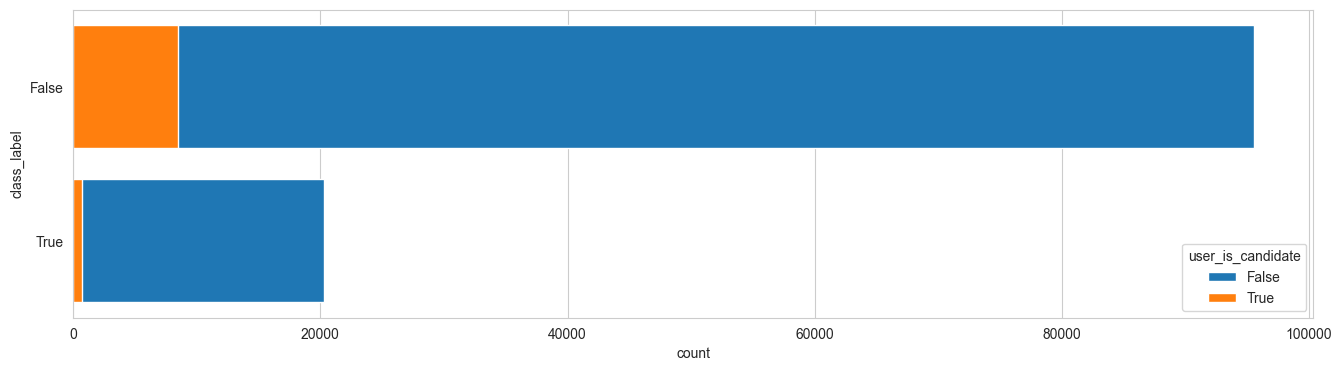

In [34]:
plt.figure(figsize=(16, 4))
sns.countplot(
    df,
    y='class_label',
    hue='user_is_candidate',
    dodge=False,
    orient='v',
    saturation=1,
)

Aproximadamente 17% dos tweets analisados receberam a flag de conteúdo ofensivo

#### Tweets de conteúdo repetido

In [35]:
# Checando tweets com conteúdo igual, que acontece principalmente em dois cenários:
# - Vários usuários postando exatamente a mesma mensagem para um candidato
# - Um usuário postando exatamente a mesma mensagem para vários candidatos diferentes
repeated_tweets = (df['filtered_content'].value_counts() > 1).loc[lambda x: x == True].index
repeated_tweets = df[df['filtered_content'].isin(repeated_tweets)]
indexes = repeated_tweets['filtered_content'].sort_values().index
repeated_tweets = repeated_tweets.reindex(indexes)

print(f'Tweets de conteúdo repetido: {repeated_tweets.shape[0]}')
print(f'Proporção de tweets repetidos: {repeated_tweets.shape[0] / df.shape[0]}')

print(f'\nProporção de conteúdo ofensivo nos tweets repetidos: \n{repeated_tweets["class_label"].value_counts(normalize=True)}')

Tweets de conteúdo repetido: 12397
Proporção de tweets repetidos: 0.09908721785280389

Proporção de conteúdo ofensivo nos tweets repetidos: 
False    0.849157
True     0.150843
Name: class_label, dtype: float64


A proporção de tweets com conteúdo repetido e ofensivo é semelhante à encontrada no total de tweets

## Calculando e analisando métricas

### Métricas das contas

,TW_followersCount,TW_friendsCount,TW_statusesCount,TW_favouritesCount
count,5.950000e+02,595.000000,595.000000,595.000000
mean,3.640129e+04,859.373109,4545.347899,4636.778151
std,1.996869e+05,3419.618106,9944.028089,18233.831219
min,0.000000e+00,0.000000,0.000000,0.000000
5%,0.000000e+00,0.000000,0.000000,0.000000
25%,1.500000e+01,25.000000,33.000000,5.500000
50%,2.530000e+02,172.000000,540.000000,217.000000
75%,2.977000e+03,600.500000,4293.500000,2114.500000
95%,9.908660e+04,3150.100000,21053.300000,19288.200000
max,2.563232e+06,64371.000000,83582.000000,257023.000000


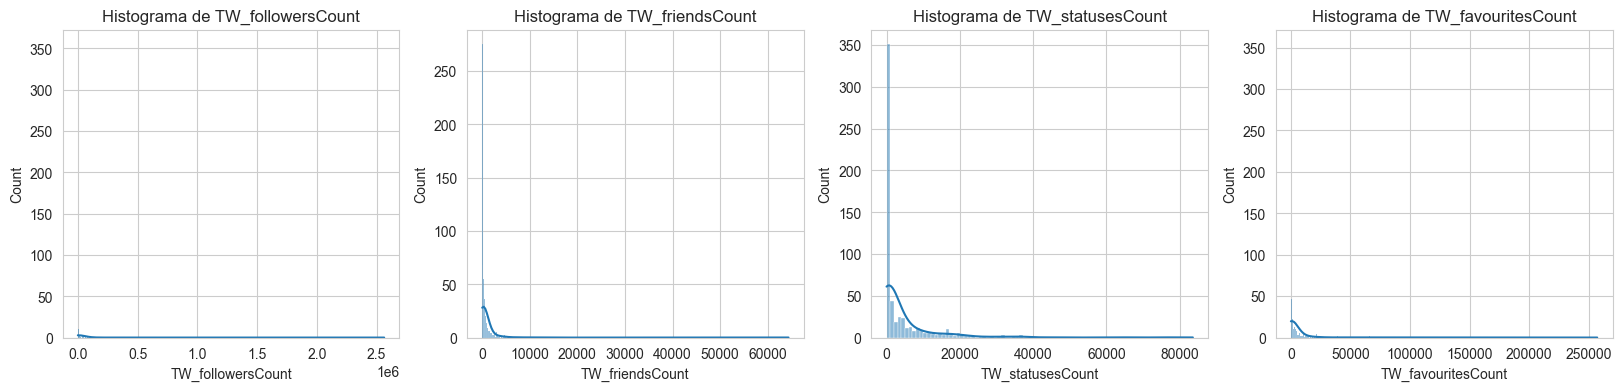

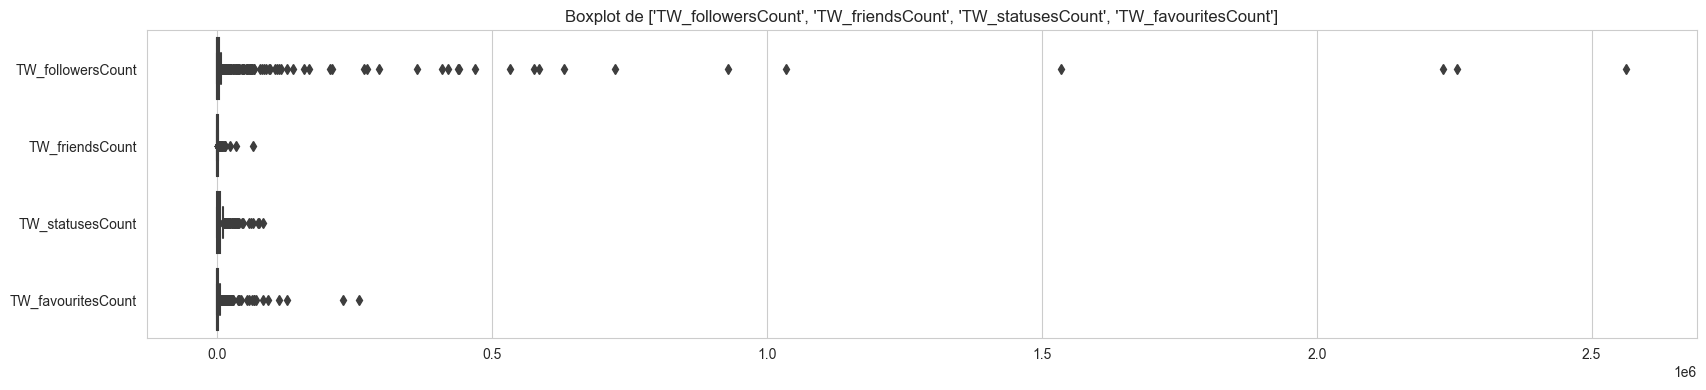

In [36]:
account_metric_cols = ['TW_followersCount', "TW_friendsCount", "TW_statusesCount", "TW_favouritesCount",]

print_quant_data(cand_df, account_metric_cols, 'TW_followersCount')
plot_cols(cand_df, account_metric_cols)

### Métricas de atividade e engajamento

In [37]:
def get_tweets(user):
    """Total de tweets postados pelo usuário"""
    _df = df[df['user'] == user]
    return _df.shape[0]

def get_threads(user):
    """Total de threads criadas pelo usuário"""
    _df = df[df['user'] == user]
    threads = _df[_df['in_reply_to_user'].isna()]
    return threads.shape[0]

def get_replies(user):
    """Total de replies recebidas pelo usuário"""
    _df = df[df['in_reply_to_user'] == user]
    return _df.shape[0]

def get_thread_tts(user):
    """Total de tweets postados em threads do usuário (incluindo os próprios tweets do usuario)"""
    _df = df[df['conversation_user'] == user]
    return _df.shape[0]

cand_df['TW_tweets'] = cand_df['TW_USER'].apply(get_tweets)
cand_df['TW_threads'] = cand_df['TW_USER'].apply(get_threads)
cand_df['TW_replies'] = cand_df['TW_USER'].apply(get_replies)
cand_df['TW_thread_tts'] = cand_df['TW_USER'].apply(get_thread_tts)

direct_activity_cols = ['TW_tweets', 'TW_threads', 'TW_replies', 'TW_thread_tts',]

side_by_side(
    cand_df[direct_activity_cols].describe(percentiles=percentiles),
    cand_df[['TW_USER'] + direct_activity_cols].sort_values('TW_thread_tts', ascending=False).head(10)
)

,TW_tweets,TW_threads,TW_replies,TW_thread_tts
count,595.000000,595.000000,595.000000,595.000000
mean,15.781513,12.174790,196.168067,210.272269
std,84.389345,62.100898,1991.229068,2045.490857
min,0.000000,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
95%,77.900000,73.100000,17.200000,116.000000
max,1166.000000,660.000000,38630.000000,39422.000000


In [38]:
# Muitos candidatos não fizeram nenhuma postagem, portanto vamos remove-los e avaliar os números novamente
cand_df = cand_df[cand_df['TW_threads'] > 0]
print(cand_df.shape)

(47, 24)


,TW_tweets,TW_threads,TW_replies,TW_thread_tts
count,47.000000,47.000000,47.000000,47.000000
mean,196.404255,154.127660,2482.617021,2661.957447
std,236.108731,165.665144,6737.989861,6881.892235
min,1.000000,1.000000,0.000000,1.000000
5%,5.300000,4.600000,0.300000,7.900000
25%,39.000000,30.000000,4.000000,91.000000
50%,125.000000,102.000000,44.000000,154.000000
75%,243.500000,197.500000,525.500000,791.500000
95%,650.000000,519.000000,13880.200000,14345.900000
max,1166.000000,660.000000,38630.000000,39422.000000


,TW_USER,TW_tweets
861,andreawerner_,1166
234,samiabomfim,832
1093,rosangelamorosp,665
734,carteiroreaca,615
679,carlosgiannazi,514
,TW_USER,TW_threads
234,samiabomfim,660
1093,rosangelamorosp,636
861,andreawerner_,525
734,carteiroreaca,505


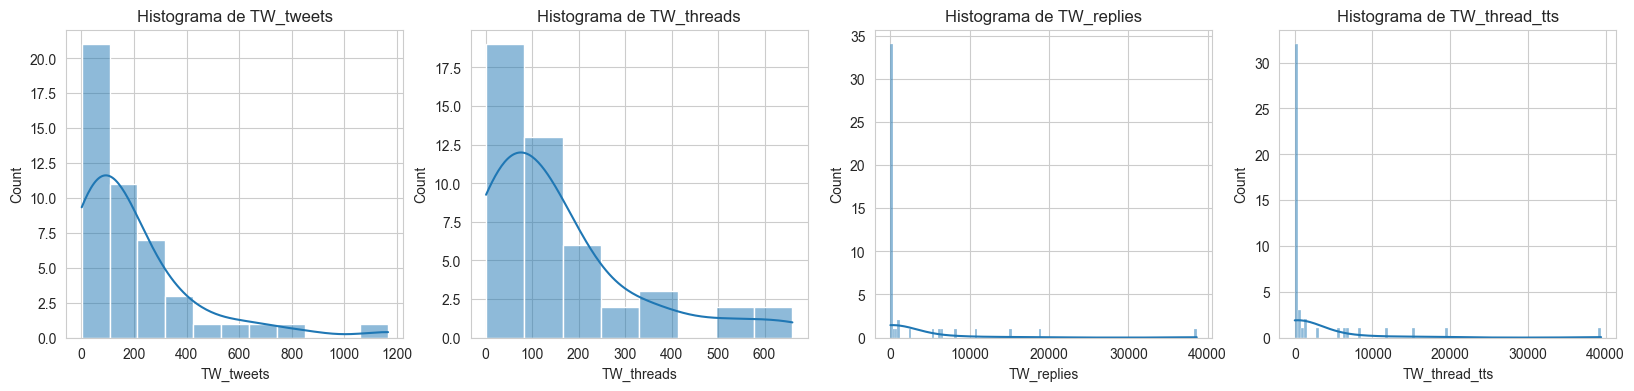

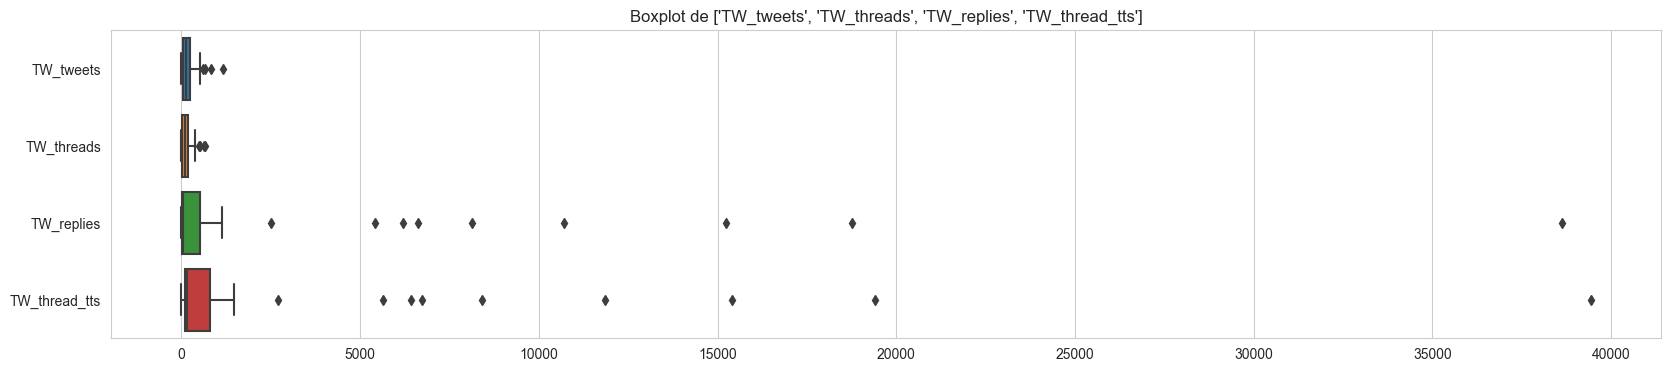

In [39]:
print_quant_data(cand_df, direct_activity_cols, 'TW_thread_tts')

side_by_side(
    cand_df[['TW_USER', 'TW_tweets']].sort_values('TW_tweets', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_threads']].sort_values('TW_threads', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_replies']].sort_values('TW_replies', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_thread_tts']].sort_values('TW_thread_tts', ascending=False).head(5),
)

plot_cols(cand_df, direct_activity_cols)

Podemos perceber alguns outliers nas quatro métricas, mas as diferenças são bem mais acentuadas em `TW_replies` e `TW_thread_tts`. Isso nos mostra que o engajamento recebido pelos usuarios pode ser bastante desigual e irregular, e é provável que isso impacte nas métricas de conteúdo ofensivo.

Além disso, a coluna `TW_replies` tem valores muito próximos de `TW_thread_tts`, indicando que as threads sejam pouco profundas (ou seja, possuem poucos níveis de replies) e que a grande maioria dos tweets são respostas diretas à quem iniciou as threads.

### Tratando outliers

Vamos filtrar os outliers para que não impactem nas análises seguintes. Por ser a coluna com maior variação, vamos centrar na `TW_thread_tts`.

In [40]:
cand_df['TW_thread_tts'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count       47.000000
mean      2661.957447
std       6881.892235
min          1.000000
1%           1.460000
25%         91.000000
50%        154.000000
75%        791.500000
90%       7398.400000
95%      14345.900000
99%      30212.800000
max      39422.000000
Name: TW_thread_tts, dtype: float64

In [41]:
limit = 7398.4  # 90th percentil
filtered_cand_df = cand_df[cand_df['TW_thread_tts'] > limit]
cand_df = cand_df[cand_df['TW_thread_tts'] <= limit]

cand_df['TW_thread_tts'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count      42.000000
mean      728.690476
std      1636.942904
min         1.000000
1%          1.410000
25%        70.000000
50%       139.500000
75%       265.000000
90%      1476.000000
95%      5486.150000
99%      6595.670000
max      6724.000000
Name: TW_thread_tts, dtype: float64

,TW_tweets,TW_threads,TW_replies,TW_thread_tts
count,42.000000,42.000000,42.000000,42.000000
mean,147.785714,123.833333,600.690476,728.690476
std,150.823194,130.220810,1606.267306,1636.942904
min,1.000000,1.000000,0.000000,1.000000
5%,5.050000,4.100000,0.050000,7.150000
25%,30.500000,21.250000,3.250000,70.000000
50%,106.500000,92.500000,34.000000,139.500000
75%,208.500000,162.000000,113.750000,265.000000
95%,403.600000,369.750000,5262.050000,5486.150000
max,665.000000,636.000000,6623.000000,6724.000000


,TW_USER,TW_tweets
1093,rosangelamorosp,665
679,carlosgiannazi,514
957,bfeministapsol,404
676,julianapt,396
1015,leosiqueirabr,389
,TW_USER,TW_threads
1093,rosangelamorosp,636
676,julianapt,374
679,carlosgiannazi,371
957,bfeministapsol,346


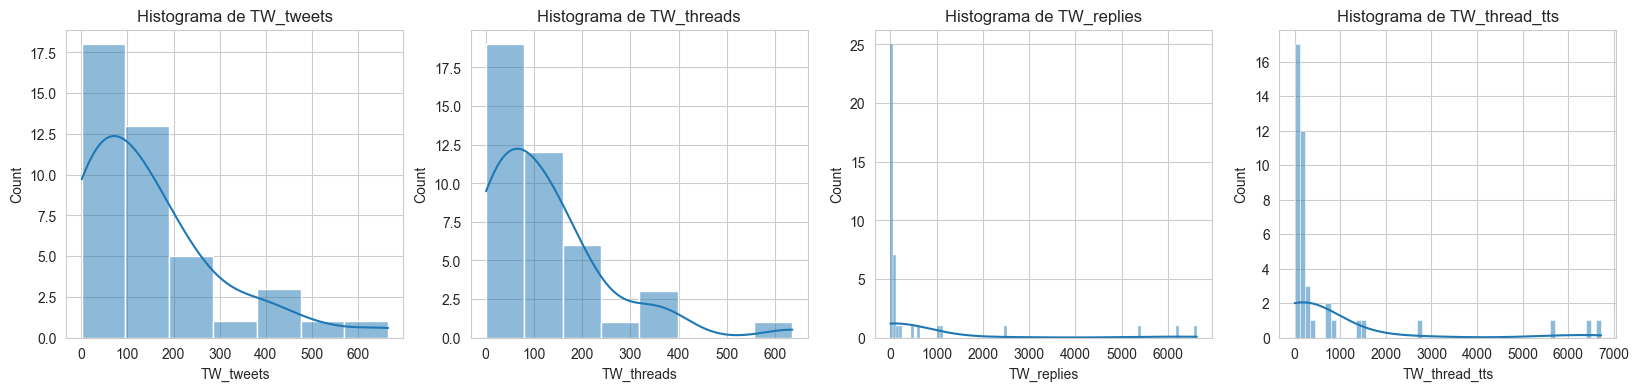

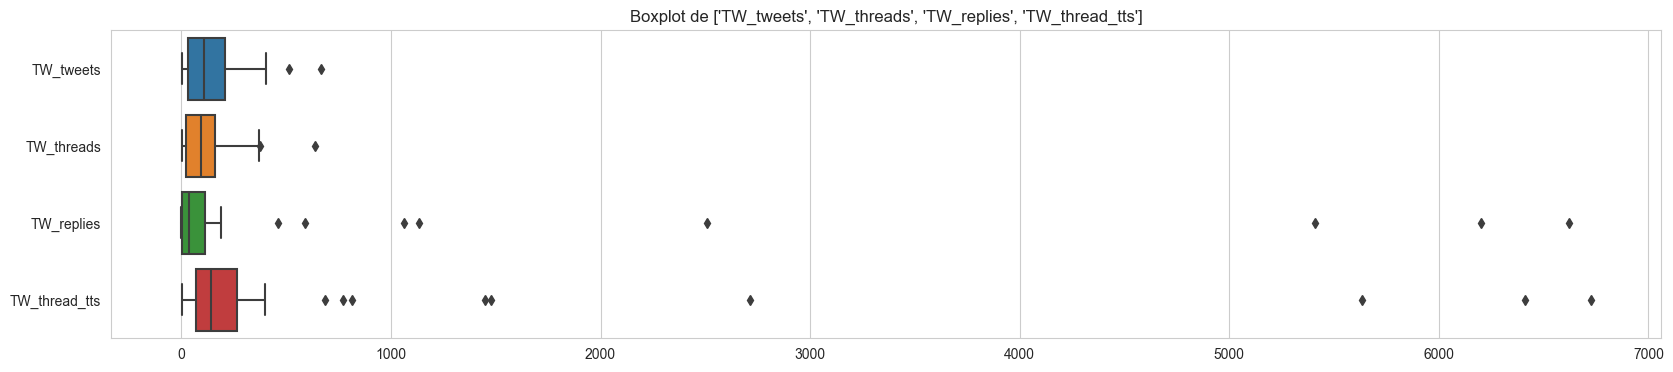

In [42]:
print_quant_data(cand_df, direct_activity_cols, 'TW_thread_tts')

side_by_side(
    cand_df[['TW_USER', 'TW_tweets']].sort_values('TW_tweets', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_threads']].sort_values('TW_threads', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_replies']].sort_values('TW_replies', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_thread_tts']].sort_values('TW_thread_tts', ascending=False).head(5),
)

plot_cols(cand_df, direct_activity_cols)

### Métricas de tamanho dos tweets

,TW_avg_tt_length,TW_std_tt_length
count,42.000000,41.000000
mean,175.403211,75.510477
std,50.429477,21.920402
min,62.052632,16.975026
5%,83.287965,36.895724
25%,149.565111,62.975995
50%,172.725956,82.423675
75%,212.425769,86.847746
95%,255.582472,101.352189
max,280.000000,127.279221


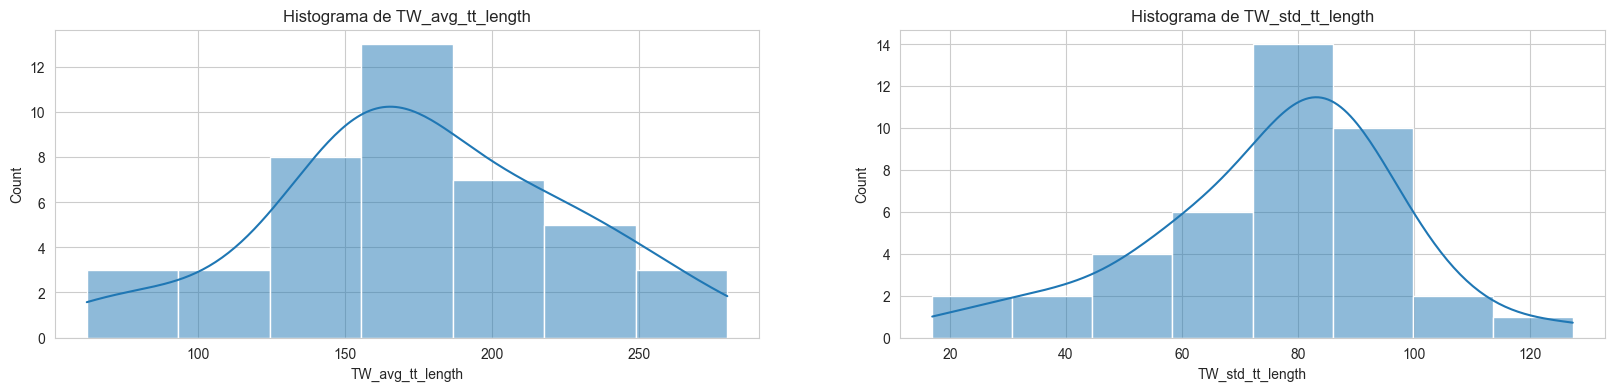

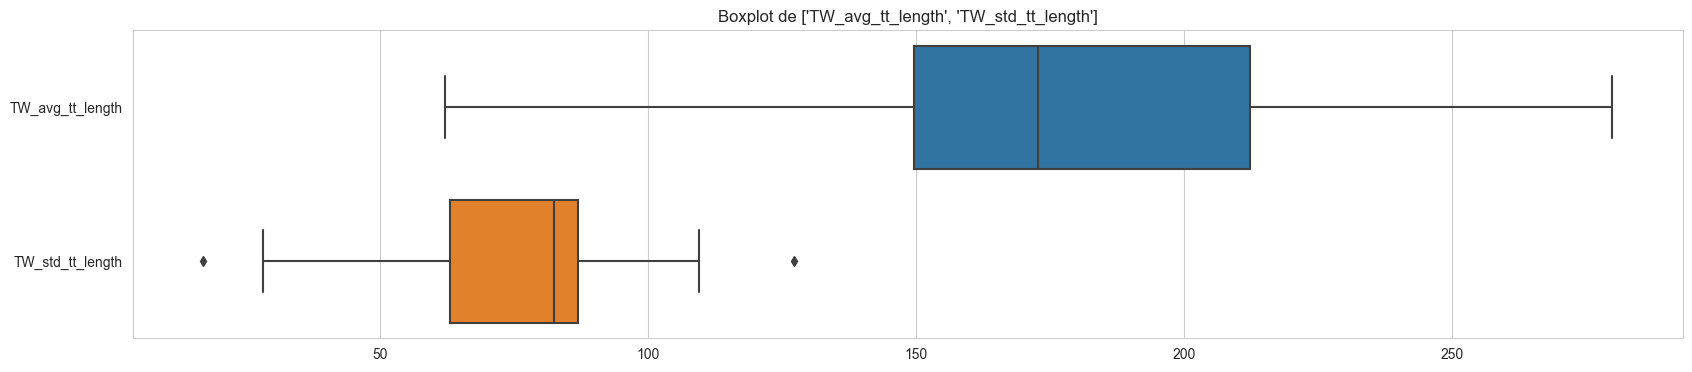

In [43]:
def get_avg_tt_length(user):
    _df = df[df['user'] == user]
    return _df.content.str.len().mean()

def get_std_tt_length(user):
    _df = df[df['user'] == user]
    return _df.content.str.len().std()

cand_df['TW_avg_tt_length'] = cand_df['TW_USER'].apply(get_avg_tt_length)
cand_df['TW_std_tt_length'] = cand_df['TW_USER'].apply(get_std_tt_length)
tweet_length_cols = ['TW_avg_tt_length', 'TW_std_tt_length',]

print_quant_data(cand_df, tweet_length_cols, 'TW_avg_tt_length')
plot_cols(cand_df, tweet_length_cols)

### Métricas de composição das threads

In [44]:
def get_user_thread_tts(user):
    """Total de tweets postados pelo usuário em suas threads"""
    _df = df[
        (df['conversation_user'] == user) & 
        (df['user'] == user)
    ]
    return _df.shape[0]

def get_reply_thread_tts(user):
    """Total de replies ao usuário, em threads do usuário"""
    _df = df[
        (df['conversation_user'] == user) & 
        (df['in_reply_to_user'] == user) & 
        (df['user'] != user)
    ]
    return _df.shape[0]
    
def get_non_reply_thread_tts(user):
    """Total de tweets postados em threads do usuário, mas que não envolvem o usuário diretamente"""
    _df = df[
        (df['conversation_user'] == user) & 
        (df['in_reply_to_user'] != user) & 
        (df['user'] != user)
    ]
    return _df.shape[0]

cand_df['TW_user_thread_tts'] = cand_df['TW_USER'].apply(get_user_thread_tts)
cand_df['TW_reply_thread_tts'] = cand_df['TW_USER'].apply(get_reply_thread_tts)
cand_df['TW_non_reply_thread_tts'] = cand_df['TW_USER'].apply(get_non_reply_thread_tts)

thread_comp_cols = ['TW_user_thread_tts', 'TW_reply_thread_tts', 'TW_non_reply_thread_tts']

,TW_user_thread_tts,TW_reply_thread_tts,TW_non_reply_thread_tts
count,42.000000,42.000000,42.000000
mean,147.166667,580.738095,0.785714
std,150.579841,1598.674452,2.124603
min,1.000000,0.000000,0.000000
5%,5.050000,0.000000,0.000000
25%,29.000000,1.000000,0.000000
50%,106.500000,11.000000,0.000000
75%,203.250000,79.750000,0.000000
95%,403.600000,5242.000000,4.950000
max,665.000000,6623.000000,10.000000


,TW_USER,TW_user_thread_tts
1093,rosangelamorosp,665
679,carlosgiannazi,514
957,bfeministapsol,404
676,julianapt,396
1015,leosiqueirabr,389
,TW_USER,TW_reply_thread_tts
403,marcofeliciano,6623
671,esuplicy,6152
113,pauloteixeira13,5396
1015,leosiqueirabr,2316


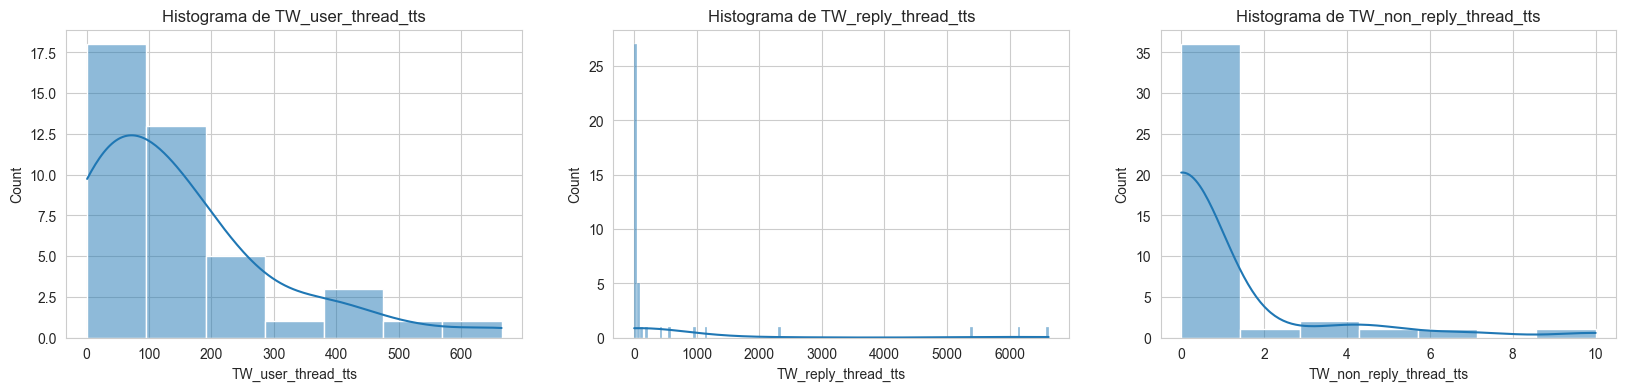

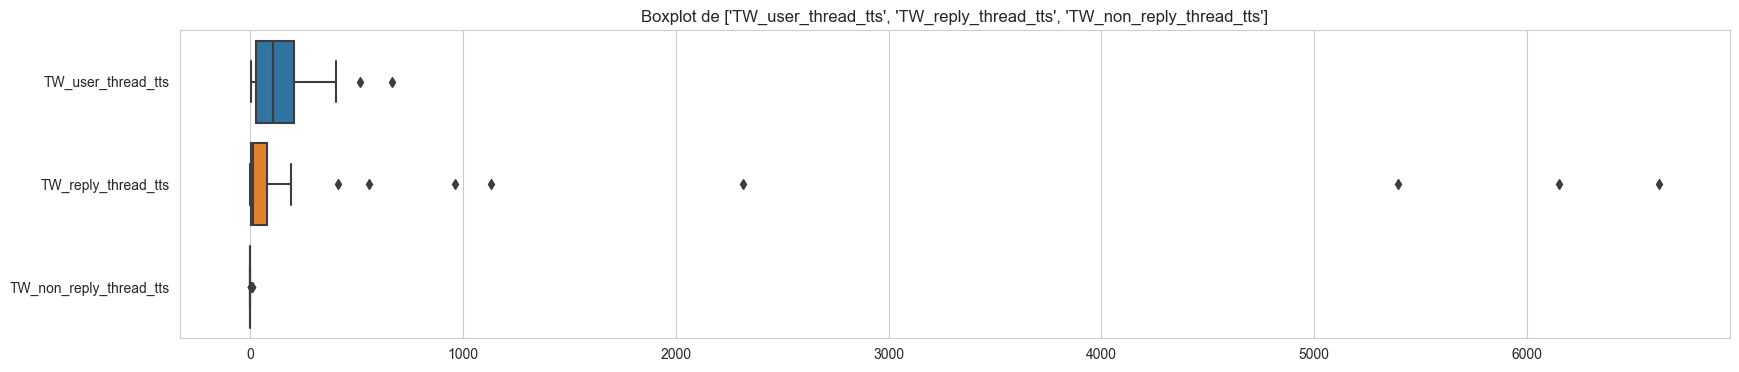

In [45]:
print_quant_data(cand_df, thread_comp_cols, 'TW_non_reply_thread_tts')

side_by_side(
    cand_df[['TW_USER', 'TW_user_thread_tts']].sort_values('TW_user_thread_tts', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_reply_thread_tts']].sort_values('TW_reply_thread_tts', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_non_reply_thread_tts']].sort_values('TW_non_reply_thread_tts', ascending=False).head(5),
)

plot_cols(cand_df, thread_comp_cols)

In [46]:
# Vamos checar a proporção de tipo de tweet em nosso dataset
means_sum = sum(cand_df[thread_comp_cols].mean())
cand_df[thread_comp_cols].mean() / means_sum

TW_user_thread_tts         0.201960
TW_reply_thread_tts        0.796961
TW_non_reply_thread_tts    0.001078
dtype: float64

Estes números confirmam que a grande maioria dos tweets são respostas diretas aos criadores das threads, e portanto podemos ignorar os tweets que não envolvem os criadores de threads: 
- **~7%:** tweets dos criadores das threads
- **~92%:** replies diretas aos criadores das threads
- **~0.01%:** replies que não envolvem os criadores das threads

Antes de seguir com as análises de conteúdo ofensivo, vamos calcular também algumas taxas relacionadas ao engajamento

### Métricas proporcionais de engajamento

In [47]:
"""
Média de tweets do usuario por threads do usuário. 
Indica o quanto o usuario interage com outros tweets dentro de suas threads
"""
cand_df['TW_avg_thread_user_tts'] = cand_df['TW_tweets'] / cand_df['TW_threads']

"""
Média de tweets do usuario pelo total de tweets em suas threads. 
Indica o quanto do engajamento das threads vem do próprio usuário
"""
cand_df['TW_avg_thread_part'] = cand_df['TW_tweets'] / cand_df['TW_thread_tts']

"""
Média de replies que o usuário recebe para cada tweet postado.
Indica se o usuário recebe um alto engajamento direto
"""
cand_df['TW_avg_replies'] = cand_df['TW_replies'] / cand_df['TW_tweets']

"""
Média do total de tweets por thread do usuário.
Indica o engajamento geral nas threads do usuário
"""
cand_df['TW_avg_thread_tts'] = cand_df['TW_thread_tts'] / cand_df['TW_threads']

prop_activity_cols = ['TW_avg_thread_user_tts', 'TW_avg_thread_part', 'TW_avg_replies', 'TW_avg_thread_tts']

,TW_avg_thread_user_tts,TW_avg_thread_part,TW_avg_replies,TW_avg_thread_tts
count,42.000000,42.000000,42.000000,42.000000
mean,1.214961,0.675251,3.670111,5.427745
std,0.372291,0.333573,11.250647,12.046336
min,1.000000,0.014723,0.000000,1.000000
5%,1.000000,0.045481,0.000231,1.000233
25%,1.001163,0.437462,0.070367,1.075835
50%,1.074866,0.720424,0.595775,1.696970
75%,1.234866,0.995713,1.293182,2.936184
95%,1.816273,1.000000,22.238085,25.053372
max,3.039062,1.007937,66.898990,69.319588


,TW_USER,TW_avg_thread_user_tts
1015,leosiqueirabr,3.039062
947,lcmarcolino,1.916667
186,rafaelsaraivasp,1.818182
1019,felipebecari,1.780000
369,itamar_borges,1.662791
,TW_USER,TW_avg_thread_part
911,rfalcao13,1.007937
16,pauloabarbosa,1.000000
807,jilmartatto,1.000000
155,kikoceleguim,1.000000


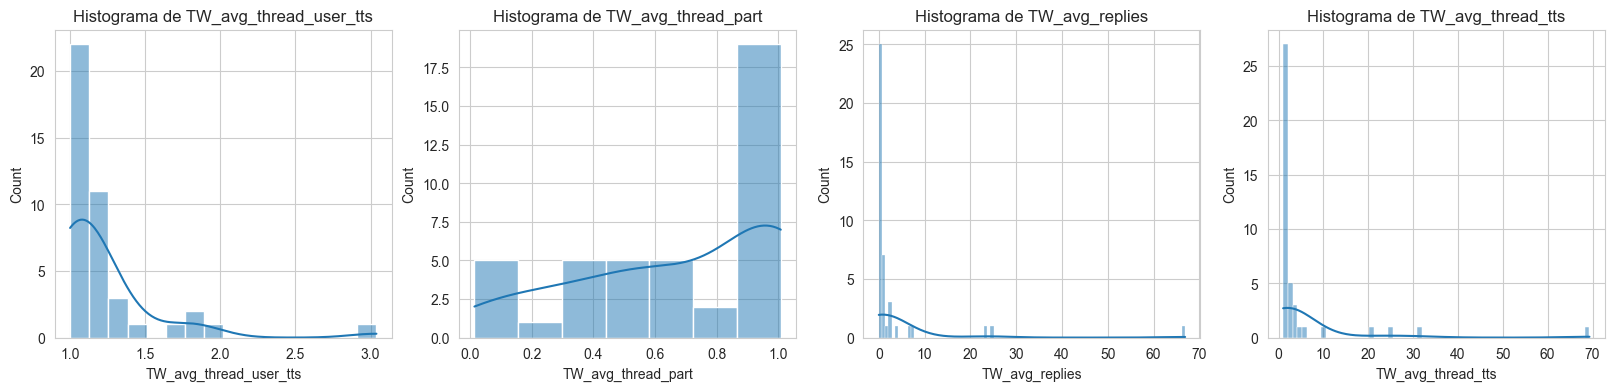

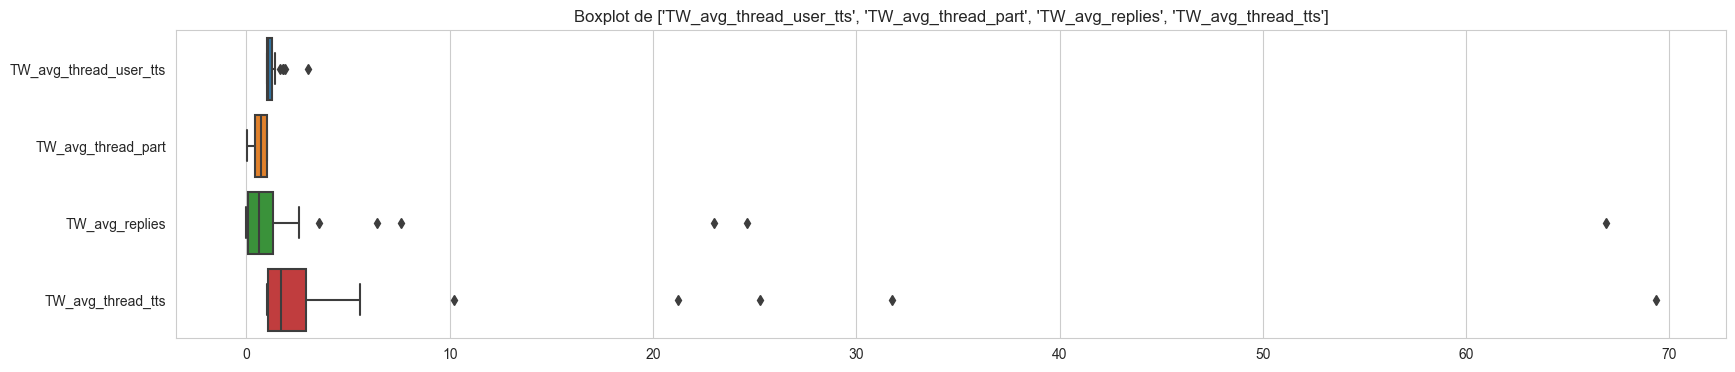

In [48]:
print_quant_data(cand_df, prop_activity_cols, 'TW_avg_thread_tts')
side_by_side(
    cand_df[['TW_USER', 'TW_avg_thread_user_tts']].sort_values('TW_avg_thread_user_tts', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_avg_thread_part']].sort_values('TW_avg_thread_part', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_avg_replies']].sort_values('TW_avg_replies', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_avg_thread_tts']].sort_values('TW_avg_thread_tts', ascending=False).head(5),
)
plot_cols(cand_df, prop_activity_cols)

Avaliando tanto `TW_avg_thread_user_tts`, podemos concluir que os usuários analisados não participam muito das discussões em suas threads

... 

INCOMPLETO

### Correlação entre as Métricas de Engajamento 

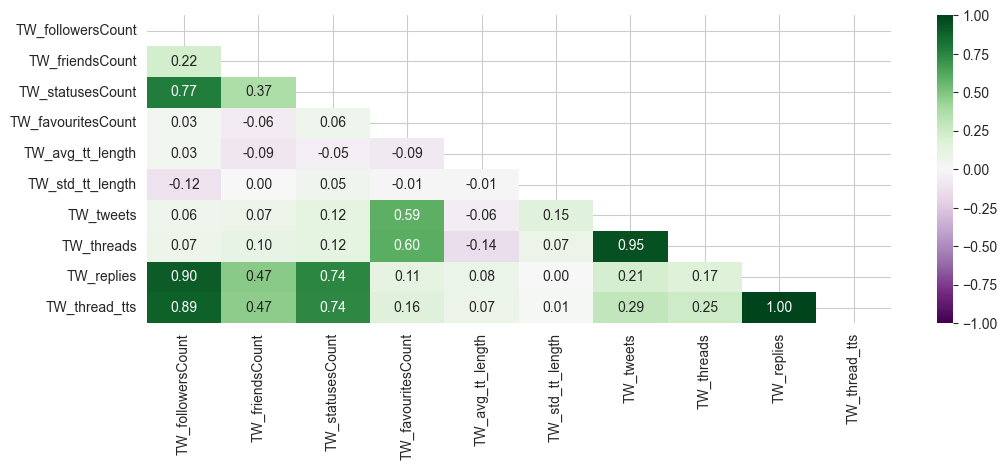

In [49]:
# Checando métricas absolutas de engajamento
_df = cand_df[account_metric_cols + tweet_length_cols + direct_activity_cols]
plot_corr_heatmap(_df)

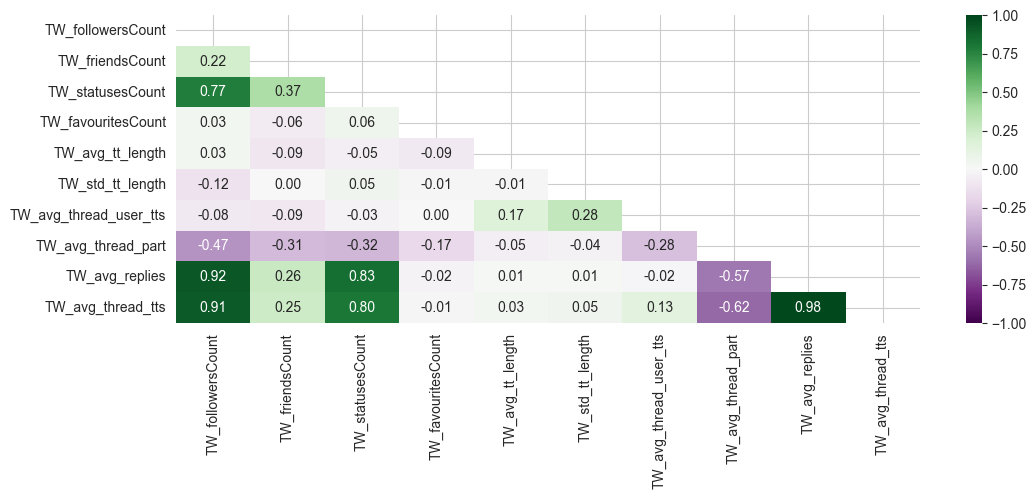

In [50]:
# Checando métricas proporcionais de engajamento
_df = cand_df[account_metric_cols + tweet_length_cols + prop_activity_cols]
plot_corr_heatmap(_df)

**TW_followersCount (quantidade de seguidores)**
- Relação forte com TW_statusesCount
    - Faz sentido que contas com mais postagens no total sejam mais ativas, e por isso atraiam mais seguidores
- Relação forte com 'TW_replies', 'TW_thread_tts', 'TW_avg_replies', 'TW_avg_thread_tts'
    - Era uma relação esperada, e demonstran o impacto da quantidade de seguidores no engajamento em suas publicações
- Relação média inversa com TW_avg_thread_part
    - Também esperado, afinal com mais engajamento externo a proporção dos próprios tweets nas threads diminui
 
**TW_favouritesCount (quantidade de postagens que curtiu)**
- Relação média com 'TW_tweets' e 'TW_threads'
    - Tanto a quantidade de postagens quanto de curtidas em outras postagens são indicadores diretos de que a conta é ativa, então faz sentido que estejam correlacionadas

### Métricas de conteúdo ofensivo

In [51]:
def get_user_offenses(user):
    """Quantidade de tweets ofensivos postados pelo usuário"""
    user_df = df[df['conversation_user'] == user]
    offenses = user_df[
        (user_df['class_label'] == True) &
        (user_df['user'] == user)
    ]
    return offenses.shape[0]

def get_reply_offenses(user):
    """Quantidade de replies ofensivas recebidas pelo usuário"""
    user_df = df[df['conversation_user'] == user]
    offenses = user_df[
        (user_df['class_label'] == True) &
        (user_df['in_reply_to_user'] == user)
    ]
    return offenses.shape[0]

def get_conversation_offenses(user):
    """Quantidade de tweets ofensivos postados em threads do usuário"""
    user_df = df[df['conversation_user'] == user]
    offenses = user_df[user_df['class_label'] == True]
    return offenses.shape[0]

cand_df['TW_user_offs'] = cand_df['TW_USER'].apply(get_user_offenses)
cand_df['TW_reply_offs'] = cand_df['TW_USER'].apply(get_reply_offenses)
cand_df['TW_thread_offs'] = cand_df['TW_USER'].apply(get_conversation_offenses)

offense_count_cols = ['TW_user_offs', 'TW_reply_offs', 'TW_thread_offs']

,TW_user_offs,TW_reply_offs,TW_thread_offs
count,42.000000,42.000000,42.000000
mean,10.404762,105.880952,115.928571
std,16.839355,316.276986,320.072811
min,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,4.500000,2.000000,8.500000
75%,13.500000,9.250000,26.750000
95%,33.950000,1013.500000,1016.800000
max,82.000000,1346.000000,1360.000000


,TW_USER,TW_user_offs
826,valbolsonaro,82
957,bfeministapsol,59
113,pauloteixeira13,34
676,julianapt,33
1093,rosangelamorosp,28
,TW_USER,TW_reply_offs
403,marcofeliciano,1346
113,pauloteixeira13,1226
671,esuplicy,1053
1015,leosiqueirabr,263


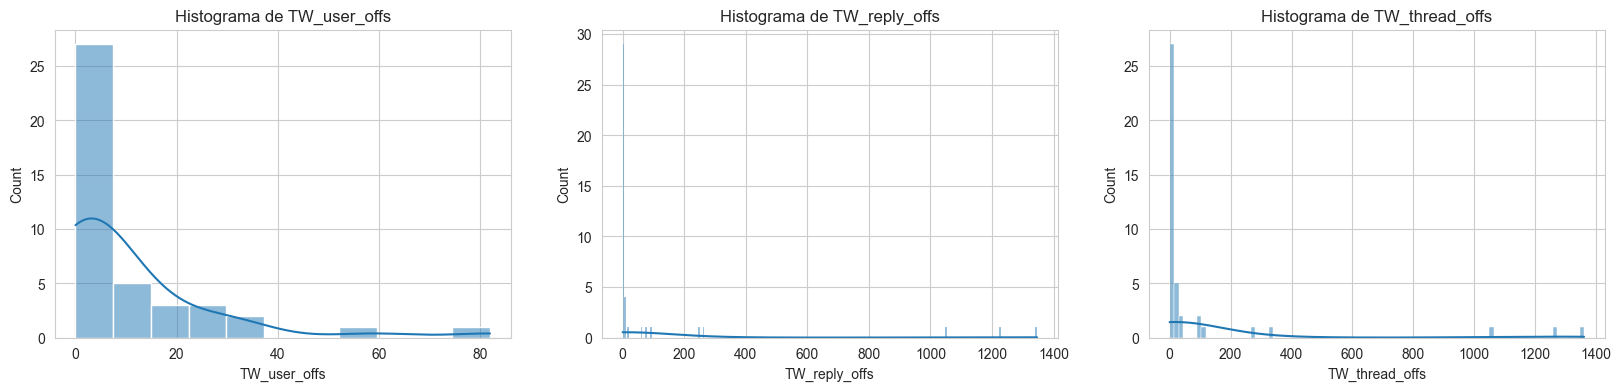

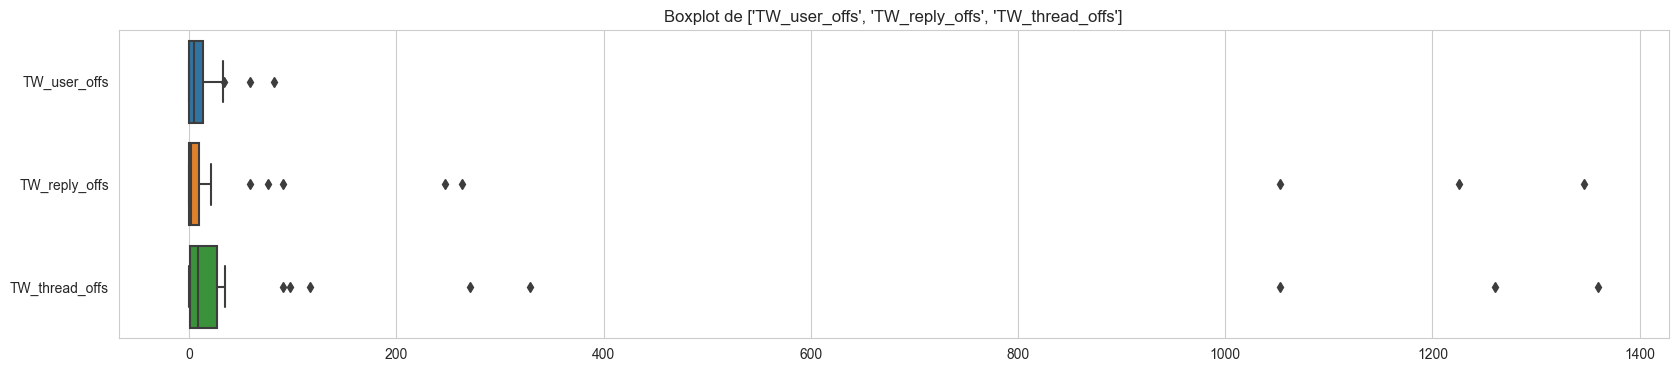

In [52]:
print_quant_data(cand_df, offense_count_cols, 'TW_thread_offs')

side_by_side(
    cand_df[['TW_USER', 'TW_user_offs']].sort_values('TW_user_offs', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_reply_offs']].sort_values('TW_reply_offs', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_thread_offs']].sort_values('TW_thread_offs', ascending=False).head(5),
)

plot_cols(cand_df, offense_count_cols)

Ao analisar a quantidade de conteudo ofensivo encontramos outliers de forma semelhante aos da análise anterior, o que pode apontar uma forte (e já esperada) correlação entre quantidade de tweets e de conteúdo ofensivo.

Vamos agora avaliar esta proporção.

In [53]:
"""Taxa de tweets ofensivos por thread do usuário"""
cand_df['TW_offs_per_thread'] = cand_df['TW_thread_offs'] / cand_df['TW_threads']

"""Taxa de tweets ofensivos pelo total de tweets postados pelo usuário"""
cand_df['TW_user_offs_rate'] = cand_df['TW_user_offs'] / cand_df['TW_tweets']

"""Taxa de replies ofensivas pelo total de replies recebidas pelo usuário"""
cand_df['TW_reply_offs_rate'] = cand_df['TW_reply_offs'] / cand_df['TW_replies']

"""Taxa de tweets ofensivos pelo total de tweets em threads do usuário"""
cand_df['TW_thread_offs_rate'] = cand_df['TW_thread_offs'] / cand_df['TW_thread_tts']

offense_prop_cols = ['TW_offs_per_thread', 'TW_user_offs_rate', 'TW_reply_offs_rate', 'TW_thread_offs_rate']

,TW_offs_per_thread,TW_user_offs_rate,TW_reply_offs_rate,TW_thread_offs_rate
count,42.000000,42.000000,39.000000,42.000000
mean,0.801828,0.060500,0.135141,0.080812
std,2.403808,0.067845,0.221828,0.065304
min,0.000000,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,0.000000
25%,0.049057,0.000000,0.000000,0.030201
50%,0.115832,0.031522,0.074074,0.061947
75%,0.248821,0.113766,0.160191,0.125853
95%,5.058087,0.166417,0.400000,0.200741
max,14.020619,0.257862,1.000000,0.227053


,TW_USER,TW_offs_per_thread
403,marcofeliciano,14.020619
113,pauloteixeira13,5.650224
671,esuplicy,5.212871
1015,leosiqueirabr,2.117188
661,lucasbovesp,1.238095
,TW_USER,TW_user_offs_rate
826,valbolsonaro,0.257862
661,lucasbovesp,0.200000
1130,carlossampaio_,0.166667
988,luizmarinhopt,0.161677


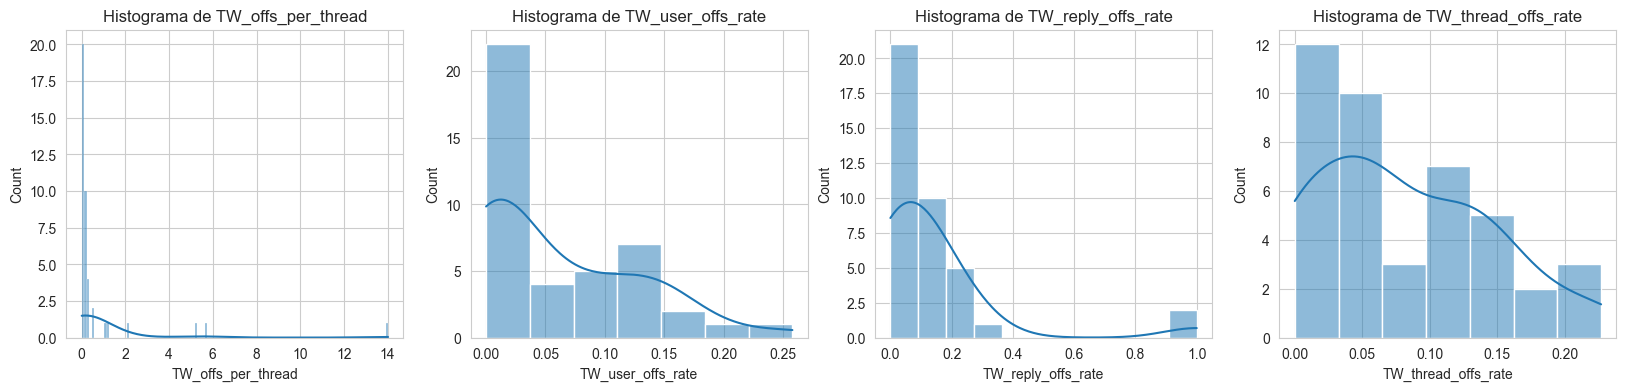

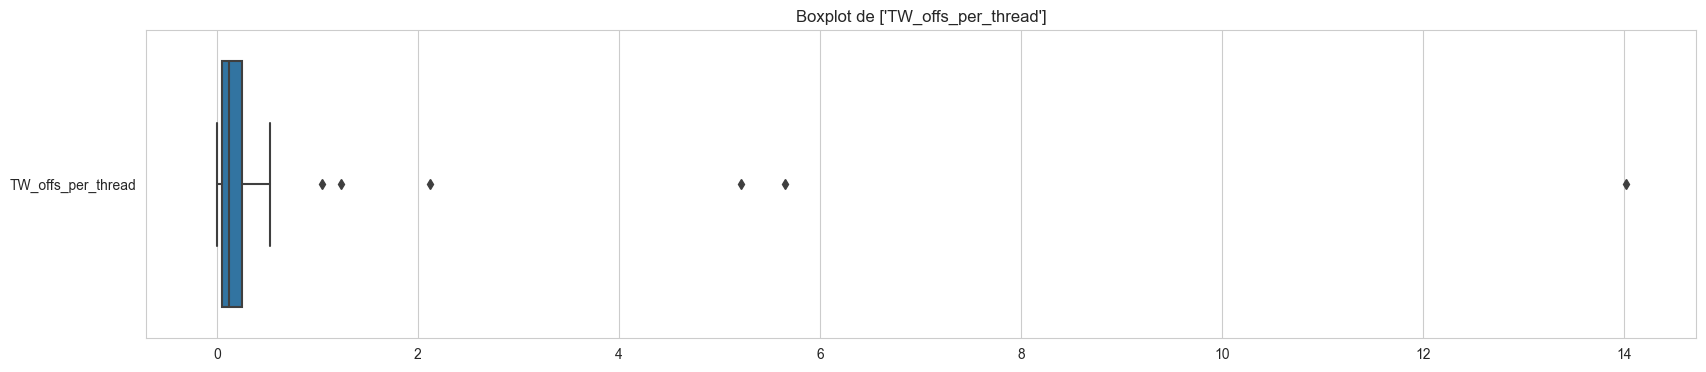

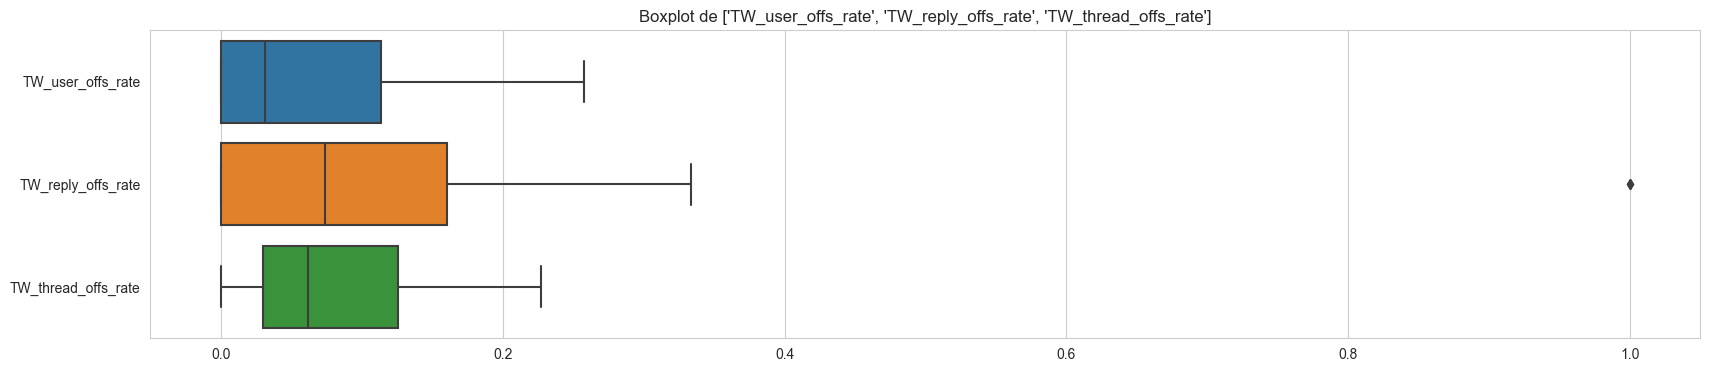

In [54]:
print_quant_data(
    cand_df, 
    offense_prop_cols, 
    'TW_thread_offs_rate'
)

side_by_side(
    cand_df[['TW_USER', 'TW_offs_per_thread']].sort_values('TW_offs_per_thread', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_user_offs_rate']].sort_values('TW_user_offs_rate', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_reply_offs_rate']].sort_values('TW_reply_offs_rate', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_thread_offs_rate']].sort_values('TW_thread_offs_rate', ascending=False).head(5),
)

plot_histograms(
    cand_df, 
    offense_prop_cols, 
)

plot_boxplots(
    cand_df, 
    [offense_prop_cols[0]], 
)

plot_boxplots(
    cand_df, 
    offense_prop_cols[1:], 
)

In [55]:
print(f"Distribuição de TW_offs_per_thread: \n{cand_df['TW_offs_per_thread'].value_counts(bins=5, normalize=True)}\n")

below_ten_prop = (cand_df[cand_df['TW_offs_per_thread'] <= 10].shape[0]) / (cand_df.shape[0])
print(f"{100*below_ten_prop:.2f}% dos candidatos tiveram até 10 tweets de conteúdo ofensivo por thread")

Distribuição de TW_offs_per_thread: 
(-0.015, 2.804]     0.928571
(2.804, 5.608]      0.023810
(5.608, 8.412]      0.023810
(11.216, 14.021]    0.023810
(8.412, 11.216]     0.000000
Name: TW_offs_per_thread, dtype: float64

97.62% dos candidatos tiveram até 10 tweets de conteúdo ofensivo por thread


Ao considerarmos proporções ao invés de números absolutos as distribuições ficaram mais contínuas, diluindo o impacto dos outliers. 

Vamos agora avaliar a correlação entre estas variáveis para poder confirmar nossas suspeitas.

### Correlações entre métricas

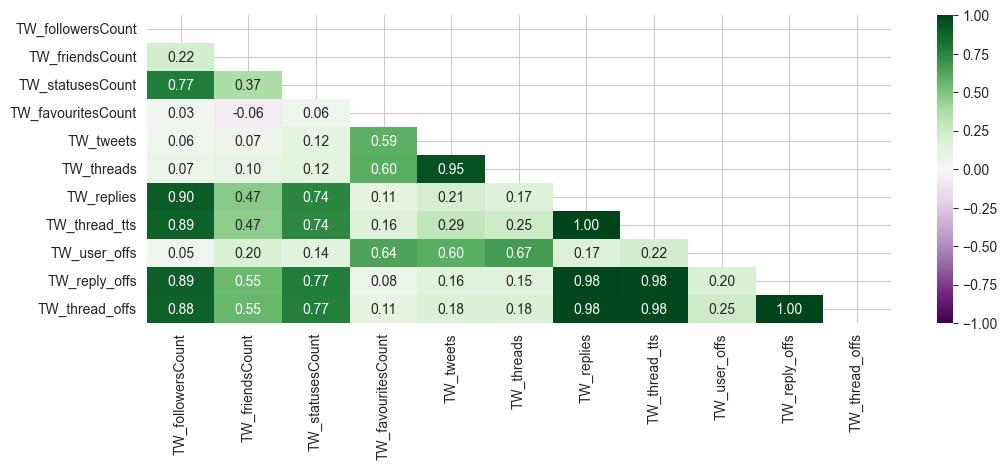

In [56]:
# Avaliando correlação entre os valores absolutos
cols = account_metric_cols + direct_activity_cols + offense_count_cols
_df = cand_df[cols]
plot_corr_heatmap(_df)

**TW_user_offs (tweets com conteúdo ofensivo postados pelo usuário)**
- Relação média com 'TW_tweets', 'TW_threads'
    - Esperado, afinal usuarios que postem mais tem maior probabilidade de postar conteúdo ofensivo
- Relação média com TW_favouritesCount
    - Esta relação chama atenção à principio, mas como TW_favouritesCount também tem uma correlação muito forte com 'TW_tweets', 'TW_threads' isso faz sentido

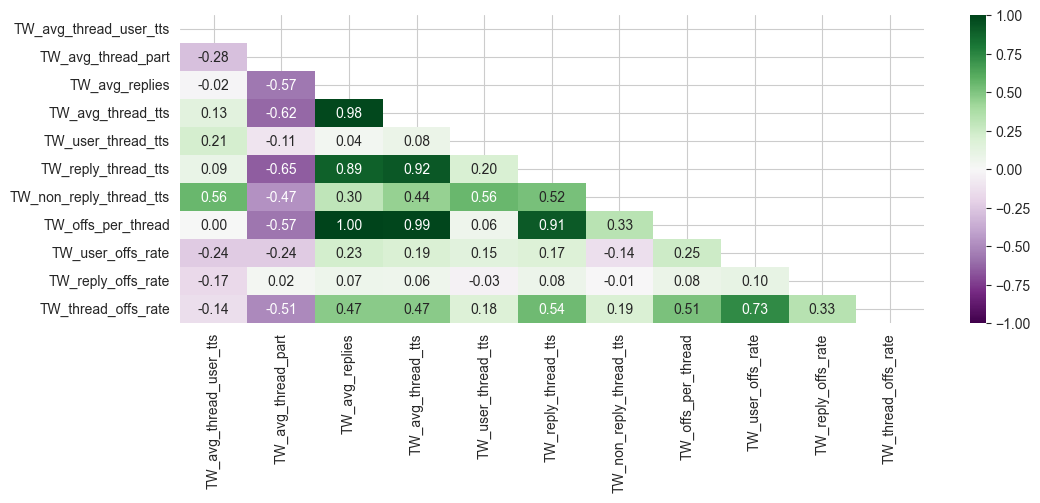

In [57]:
# Avaliando correlação entre as taxas
cols = prop_activity_cols + thread_comp_cols + offense_prop_cols
_df = cand_df[cols]

plot_corr_heatmap(_df)

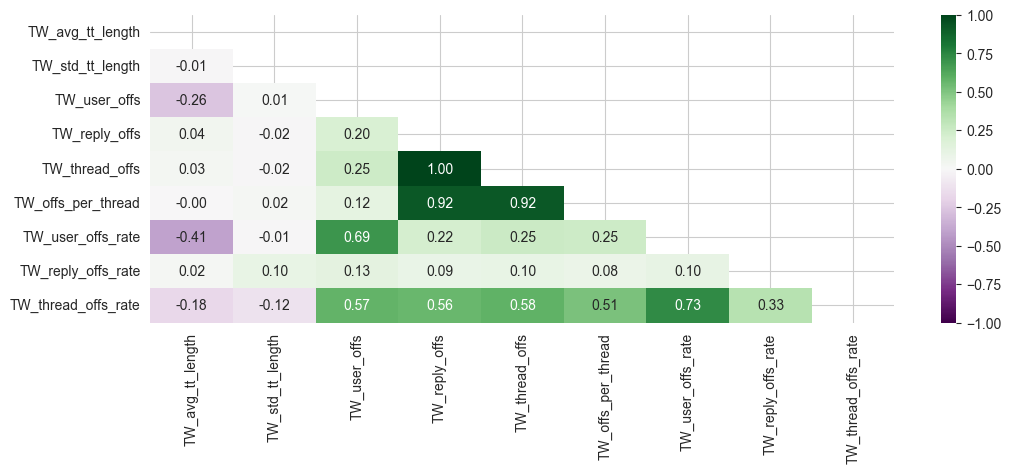

In [58]:
# Avaliando correlação entre tamanho dos tweets e conteúdo ofensivo
cols = tweet_length_cols + offense_count_cols + offense_prop_cols
_df = cand_df[cols]

plot_corr_heatmap(_df)

**TW_avg_tt_length (tamanho médio dos tweets do usuario)**
- Relação inversa média com `TW_user_offs_rate`
    - Usuários com tweets maiores tem uma pequena tendencia de redução de conteudo ofensivo

#### Investigações sobre as correlações encontradas

<Axes: >

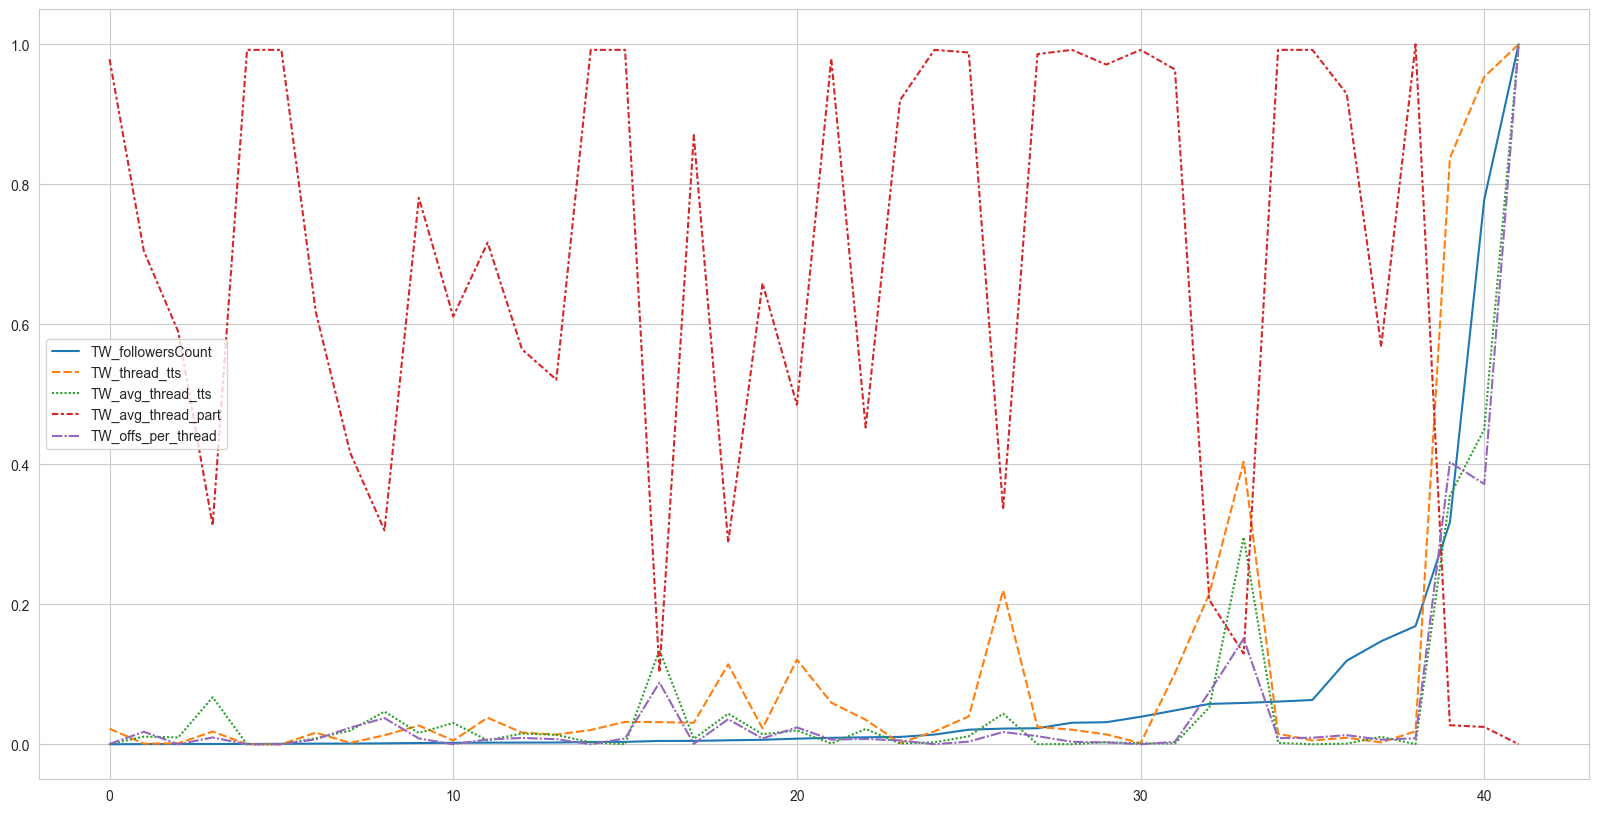

In [59]:
from sklearn.preprocessing import MinMaxScaler

corr_cols = ['TW_followersCount', 'TW_thread_tts', 'TW_avg_thread_tts', 'TW_avg_thread_part', 'TW_offs_per_thread']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(
    np.array(cand_df[corr_cols])
)
scaled_df = pd.DataFrame(scaled_data, columns=corr_cols)
scaled_df = scaled_df.sort_values('TW_followersCount')

plt.figure(figsize=(20, 10))
sns.lineplot(
    data=scaled_df.reset_index(drop=True),
)

<Axes: xlabel='TW_followersCount', ylabel='TW_offs_per_thread'>

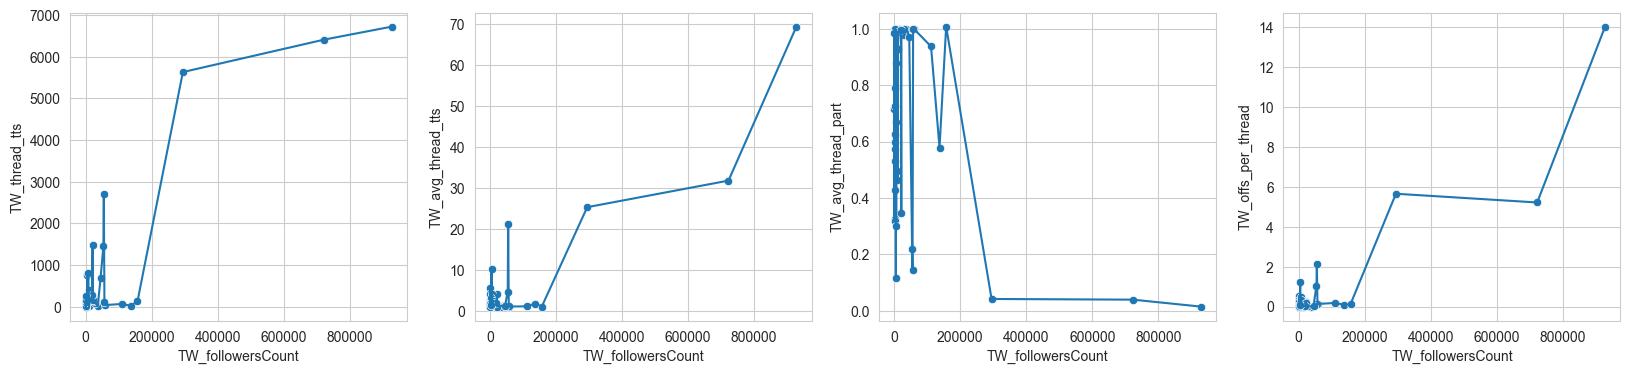

In [60]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

sns.lineplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[1],
    ax=ax[0],
)
sns.scatterplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[1],
    ax=ax[0],
)

sns.lineplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[2],
    ax=ax[1],
)
sns.scatterplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[2],
    ax=ax[1],
)

sns.lineplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[3],
    ax=ax[2],
)
sns.scatterplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[3],
    ax=ax[2],
)

sns.lineplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[4],
    ax=ax[3],
)
sns.scatterplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[4],
    ax=ax[3],
)

Como esperado, encontramos correlações muito fortes entre a quantidade de tweets postados e a ocorrência de conteúdo ofensivo, tanto com relação a quantidade de threads abertas, quanto de tamanho das threads.

# Testes de Hipóteses

In [61]:
cand_df.columns

Index(['SG_UF', 'DS_CARGO', 'SQ_CANDIDATO', 'NM_URNA_CANDIDATO', 'NR_PARTIDO',
       'SG_PARTIDO', 'NM_MUNICIPIO_NASCIMENTO', 'NR_IDADE_DATA_POSSE',
       'DS_GENERO', 'DS_GRAU_INSTRUCAO', 'DS_ESTADO_CIVIL', 'DS_COR_RACA',
       'DS_OCUPACAO', 'DS_SIT_TOT_TURNO', 'ST_REELEICAO', 'TW_USER',
       'TW_followersCount', 'TW_friendsCount', 'TW_statusesCount',
       'TW_favouritesCount', 'TW_tweets', 'TW_threads', 'TW_replies',
       'TW_thread_tts', 'TW_avg_tt_length', 'TW_std_tt_length',
       'TW_user_thread_tts', 'TW_reply_thread_tts', 'TW_non_reply_thread_tts',
       'TW_avg_thread_user_tts', 'TW_avg_thread_part', 'TW_avg_replies',
       'TW_avg_thread_tts', 'TW_user_offs', 'TW_reply_offs', 'TW_thread_offs',
       'TW_offs_per_thread', 'TW_user_offs_rate', 'TW_reply_offs_rate',
       'TW_thread_offs_rate'],
      dtype='object')

In [62]:
cols_to_check = ["DS_GENERO", "DS_COR_RACA", "DS_GRAU_INSTRUCAO", "DS_CARGO", "SG_PARTIDO", "NR_IDADE_DATA_POSSE", "ST_REELEICAO", "TW_followersCount"]

In [63]:
# Definindo as colunas quantitativas que serão testadas com colunas qualitativas
x_cols = direct_activity_cols + prop_activity_cols + thread_comp_cols + offense_count_cols + offense_prop_cols

## Gênero

In [64]:
# Visualizando a distribuição de gênero entre os tweets
print(cand_df['DS_GENERO'].value_counts(normalize=True))

MASCULINO    0.738095
FEMININO     0.261905
Name: DS_GENERO, dtype: float64


Diferença significativa encontrada nas colunas: ['TW_tweets', 'TW_threads', 'TW_user_thread_tts', 'TW_user_offs']



,col,p_value,t_stat,sig_dif
0,TW_tweets,0.029450,-2.258318,True
1,TW_threads,0.008043,-2.789661,True
8,TW_user_thread_tts,0.028474,-2.272948,True
11,TW_user_offs,0.009506,-2.724379,True


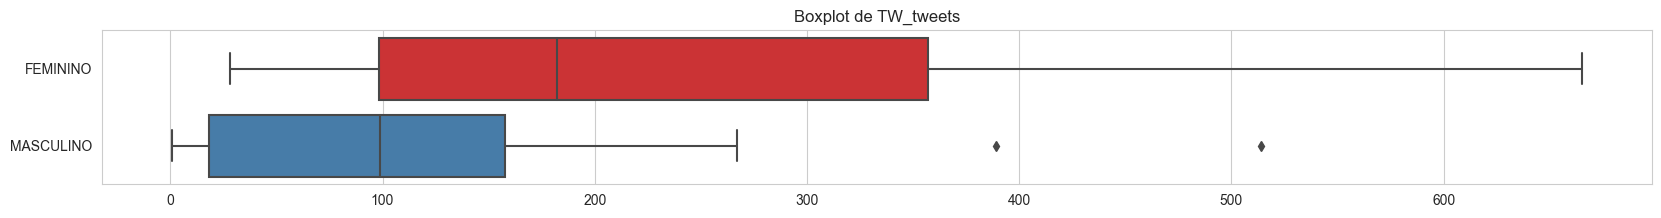

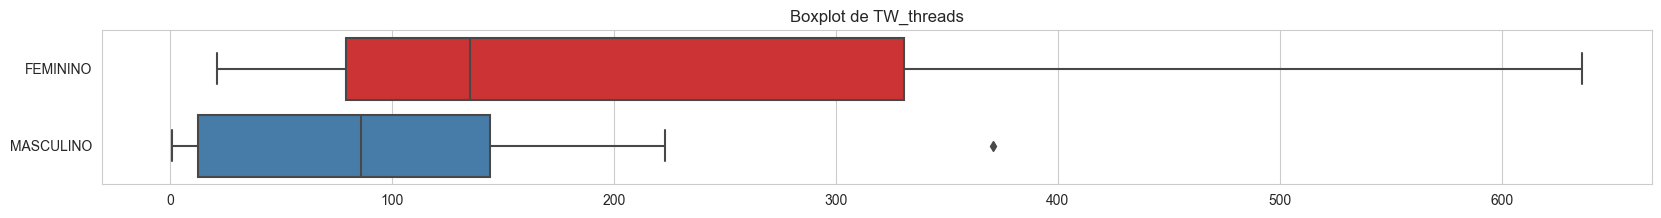

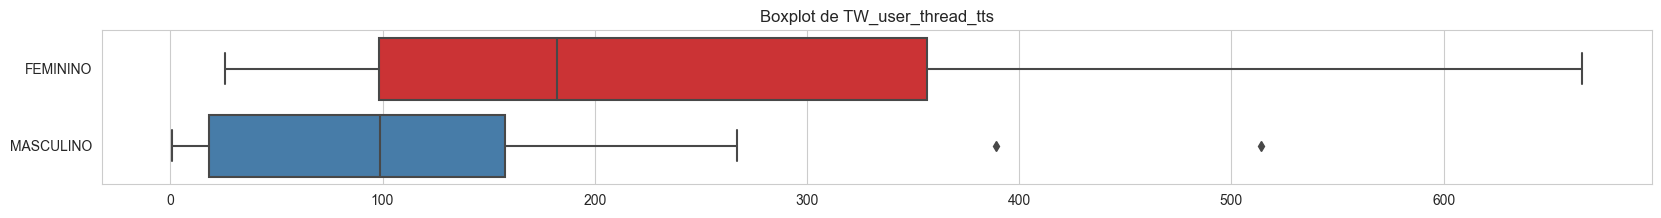

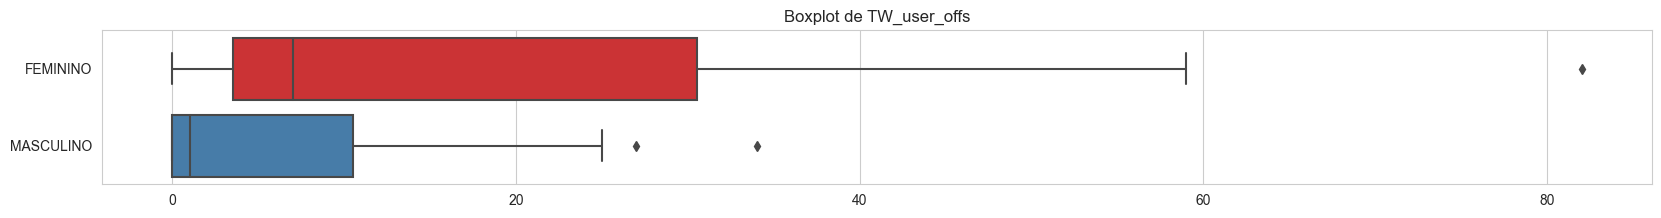

In [65]:
# Teste T de Student para comparar a diferença entre as médias por gênero
y_col = 'DS_GENERO'
y_val_0 = 'MASCULINO'
y_val_1 = 'FEMININO'
_ttest = t_test_candidate_quali_columns(cand_df, x_cols, y_col, y_val_0, y_val_1)

Foram encontradas diferenças significativas em 2 métricas diretas de atividade no Twitter: `TW_tweets` e `TW_threads`.

Também foram encontradas diferenças em `TW_user_thread_tts` (razão entre tweets do usuario e total de tweets em suas threads) e `TW_user_offs` (quantidade de tweets do usuário com conteúdo ofensivo), porém como estas colunas já possuem uma forte associação com `TW_tweets` e `TW_threads`, não podemos afirmar o gênero foi o fator determinante para a associação.

#### Cor/Raça

In [66]:
print(cand_df['DS_COR_RACA'].value_counts())

BRANCA      35
PRETA        4
PARDA        2
INDÍGENA     1
Name: DS_COR_RACA, dtype: int64


In [67]:
# Como temos quatro classes diferentes, precisamos agrupa-las em somente duas para fazer o teste de hipoteses. 
# Como a classe BRANCA já está bastante desbalanceada, vamos deixá-la como está e agrupar PRETA, PARDA e INDÍGENA como NAO-BRANCA
def get_simplified_color(color):
    if color != 'BRANCA':
        return 'NAO_BRANCA'
    return color

cand_df['DS_COR_RACA_SIMP'] = cand_df['DS_COR_RACA'].apply(get_simplified_color)
print(cand_df['DS_COR_RACA_SIMP'].value_counts())

BRANCA        35
NAO_BRANCA     7
Name: DS_COR_RACA_SIMP, dtype: int64


In [68]:
# Teste T de Student para comparar a diferença entre as médias por cor/raça
y_col = 'DS_COR_RACA_SIMP'
y_val_0 = 'BRANCA'
y_val_1 = 'NAO_BRANCA'
_ttest = t_test_candidate_quali_columns(cand_df, x_cols, y_col, y_val_0, y_val_1)

Nenhuma coluna apresentou diferença significativa para DS_COR_RACA_SIMP


#### Grau/Instrução

In [69]:
print(cand_df['DS_GRAU_INSTRUCAO'].value_counts())

SUPERIOR COMPLETO                40
ENSINO FUNDAMENTAL INCOMPLETO     1
SUPERIOR INCOMPLETO               1
Name: DS_GRAU_INSTRUCAO, dtype: int64


Os dados de DS_GRAU_INSTRUCAO estão muito desbalanceados, portanto não podemos fazer análises sobre eles

#### Cargo Político

In [70]:
tested_col = 'DS_CARGO'
print(cand_df[tested_col].value_counts())

DEPUTADO ESTADUAL    23
DEPUTADO FEDERAL     19
Name: DS_CARGO, dtype: int64


Diferença significativa encontrada nas colunas: ['TW_avg_thread_part']



,col,p_value,t_stat,sig_dif
5,TW_avg_thread_part,0.000047,-4.560981,True


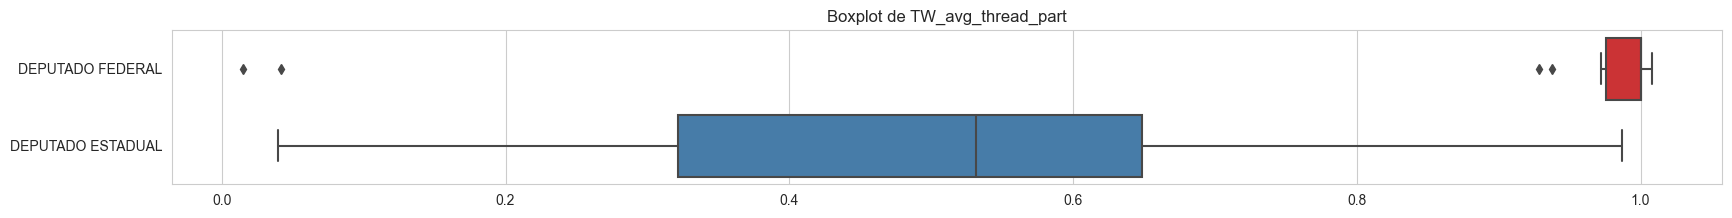

In [71]:
# Teste T de Student para comparar a diferença entre as médias por cor/raça
y_col = 'DS_CARGO'
y_val_0 = 'DEPUTADO ESTADUAL'
y_val_1 = 'DEPUTADO FEDERAL'
_ttest = t_test_candidate_quali_columns(cand_df, x_cols, y_col, y_val_0, y_val_1)

#### Candidato a Reeleição

In [72]:
tested_col = 'ST_REELEICAO'
print(cand_df[tested_col].value_counts())

N    21
S    21
Name: ST_REELEICAO, dtype: int64


In [73]:
# Teste T de Student para comparar a diferença entre as médias por cor/raça
y_col = 'ST_REELEICAO'
y_val_0 = 'N'
y_val_1 = 'S'
_ttest = t_test_candidate_quali_columns(cand_df, x_cols, y_col, y_val_0, y_val_1)

Nenhuma coluna apresentou diferença significativa para ST_REELEICAO


# Conclusão

**Correlações entre as métricas:**
- TW_avg_thread_part e -TW_offs_per_thread
- TW_avg_thread_part e -TW_thread_offs_rate

**Diferenças significativas entre categorias:**
- DS_GENERO e TW_tweets
- DS_GENERO e TW_threads
- DS_GENERO e TW_user_thread_tts
- DS_GENERO e TW_user_offs

In [74]:
display(insights)

['Coluna class_score agrupada por class_label: p_value=0.0, t_stat=96.15681667776525\nDiferença significativa encontrada',
 'Coluna content_length agrupada por class_label: p_value=0.0, t_stat=-46.68330470858772\nDiferença significativa encontrada',
 'Coluna filtered_content_length agrupada por class_label: p_value=0.0, t_stat=-47.03939857557532\nDiferença significativa encontrada',
 'Coluna TW_tweets agrupada por DS_GENERO: p_value=0.02945042991738305, t_stat=-2.258317710943822\nDiferença significativa encontrada',
 'Coluna TW_threads agrupada por DS_GENERO: p_value=0.008042682848239016, t_stat=-2.7896605181091005\nDiferença significativa encontrada',
 'Coluna TW_user_thread_tts agrupada por DS_GENERO: p_value=0.028474139179414333, t_stat=-2.2729482081486365\nDiferença significativa encontrada',
 'Coluna TW_user_offs agrupada por DS_GENERO: p_value=0.009506457747740723, t_stat=-2.724379306645775\nDiferença significativa encontrada',
 'Coluna TW_avg_thread_part agrupada por DS_CARGO: p